In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime
import pandas as pd

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/linalg/__init__.py:202: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/optimize/_trlib/__init__.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._trlib import TRLIBQuadraticSubproblem
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate bi

In [2]:
import smart
import coronagraph as cg
import pandas as pd

/Users/Jake/Projects/Packages/photochem_smart/smart/extra/gas_info.py:67: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  'mass', 'minwn', 'maxwn', 'n'])
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _bspl
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:94: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .ckdtree import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:95: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .qhull import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/_spherical_voronoi.py:18: RuntimeWarning: numpy.dtype size 

In [3]:
sys.path.insert(1, "../scripts")

import spectroscopy

In [4]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

In [560]:
# ASSUMPTIONS
wantSNR   = 10.0      # Desired SNR in each spectral element
Ahr_flat  = 0.25      # Flat planet albedo to use for SNR/exposure time estimates 
Ndraw_fid = 5         # Fiducial number of stars to draw from biased sample (eta_interesting ~ 10%)
bandwidth = 0.2       # Bandpass bandwidth

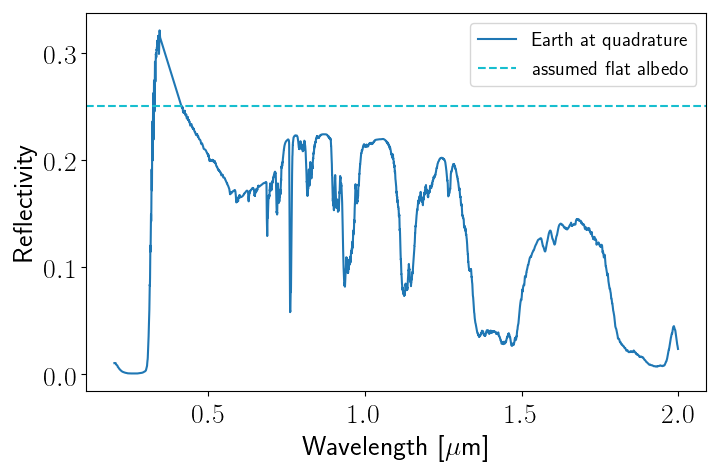

In [558]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

lammin = 0.2
lammax = 2.0
m = (lamhr > lammin) & (lamhr < lammax)

plt.plot(lamhr[m], Ahr[m], label = "Earth at quadrature")
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("Reflectivity")
plt.axhline(Ahr_flat, ls = "--", c = "C9", label = "assumed flat albedo")
plt.legend(fontsize = 14)

In [7]:
# Create generic coronagraph noise object
cn = cg.CoronagraphNoise()

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


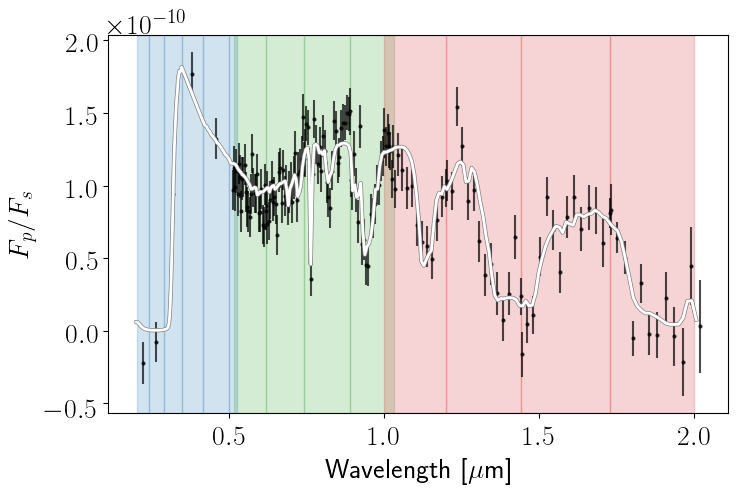

In [8]:
t_tot, tpbpc, spectrum, iwa = spectroscopy.complete_spectrum_time(cn, plot=True, wantSNR = wantSNR, Ahr_flat = Ahr_flat)

In [10]:
# Get biased stellar catalog 
biased_sample = spectroscopy.read_luvoir_stars()
biased_sample.keys()
NBIAS = len(biased_sample["dist"])

[u'hip', u'dist', u'stype']

## Calculate the exposure times and spectra in each bandpass for each star in biased sample

In [12]:
# Perform calculation for all stars in biased sample
biased_sample = spectroscopy.read_luvoir_stars()
Ndraw = NBIAS

np.random.seed(seed=None)

# Allocate memory for exposure times
t_tots = np.zeros(Ndraw)
tpbpcs = []
pct_obs_iwas = []
lammax_obs_iwas = []
specs = []

# Loop over stars in this sample
for i in range(Ndraw):
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = spectroscopy.prep_ith_star(cn, i)
    
    # Calculate the time to observe the complete spectrum
    t_tots[i], tpbpc, spectrum, iwa = spectroscopy.complete_spectrum_time(cn, plot=False, 
                                                                          wantSNR = wantSNR, 
                                                                          Ahr_flat = Ahr_flat, 
                                                                          bandwidth = bandwidth) 
    
    tpbpcs.append(tpbpc)
    pct_obs_iwas.append(iwa[0])
    specs.append(spectrum)

/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:290: RuntimeWarning: divide by zero encountered in true_divide
  Csig = self.Cratio/SNRt
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:291: RuntimeWarning: divide by zero encountered in true_divide
  Asig = self.A/SNRt
../scripts/spectroscopy.py:328: RuntimeWarning: divide by zero encountered in double_scalars
  t_snr = (wantsnr**2 - intercept) / slope
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:287: RuntimeWarning: invalid value encountered in multiply
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * Dt)
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:287: RuntimeWarning: invalid value encountered in true_divide
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * Dt)


## Calculate Spectral Completeness

In [13]:
# Calculate channel widths
deltas = []
for channel in spectroscopy.CHANNELS:
    l = spectroscopy.default_luvoir(channel=channel)
    deltas.append(l.lammax - l.lammin)
deltas = np.array(deltas)

# Calculate channel fractional completeness
channel_weights = (deltas / np.sum(deltas))

# Calculate completeness for each star in sample
completeness = np.sum(np.array(pct_obs_iwas) * channel_weights, axis = 1)

Text(0,0.5,'Total Exposure Time [hrs]')

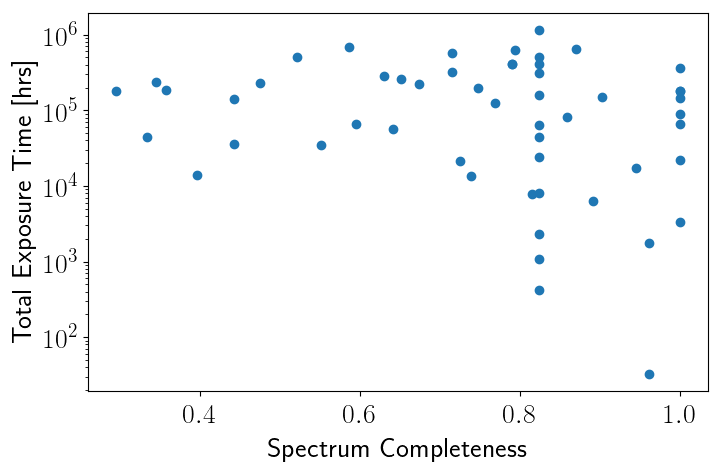

In [14]:
# Plot it!
plt.plot(completeness, t_tots, "o")
plt.yscale("log")
plt.xlabel("Spectrum Completeness")
plt.ylabel("Total Exposure Time [hrs]")

## Adjust results for removing the "worst" bandpasses (largely depreciated and replaced with deliberately removing specific bandpasses) 

In [15]:
# Max Number of channels to remove
N = 3

tpbpcs_N = [tpbpcs]
modcomps_N = np.zeros((N+1, NBIAS))
completeness_N = np.zeros((N+1, NBIAS))
t_tots_N = np.zeros((N+1, NBIAS))

modcomps_N[0,:]
completeness_N[0,:] = completeness
t_tots_N[0,:] = t_tots

for i in range(N):
    tmpt = []
    tmpc = []
    for j in range(NBIAS):
        new_tpbpc, modtime, modcomp, maxderiv = spectroscopy.remove_worst_bandpass(tpbpcs_N[-1][j], specs[j])
        tmpt.append(new_tpbpc)
        modcomps_N[i+1,j] = modcomp
        completeness_N[i+1,j] = completeness[j] - np.sum(modcomps_N[:,j])
        t_tots_N[i+1,j] = spectroscopy.apply_two_channels(spectroscopy.calc_t_chan(new_tpbpc))
    tpbpcs_N.append(tmpt)

In [16]:
new_tpbpc, modtime, modcomp, maxderiv = spectroscopy.remove_worst_bandpass(tpbpcs_N[-1][j], specs[j])

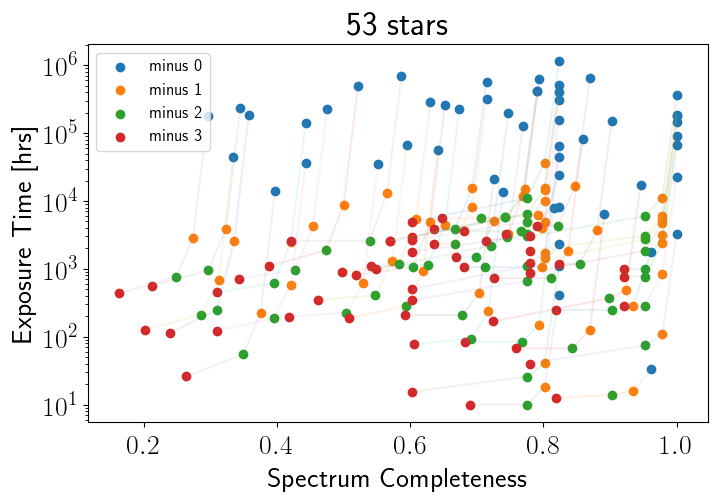

In [19]:
fig, ax = plt.subplots()

for i in range(N+1):
    s = ax.scatter(completeness_N[i,:], t_tots_N[i,:], marker = "o", label = "minus %i" %(i))

for i in range(NBIAS):
    ax.plot(completeness_N[:,i], t_tots_N[:,i], alpha = 0.1)
    
ax.set_yscale("log")
ax.set_title("%i stars" %NBIAS)
#plt.colorbar(s, label = clabel)
ax.set_xlabel("Spectrum Completeness")
ax.set_ylabel("Exposure Time [hrs]")
ax.legend(fontsize = 12)

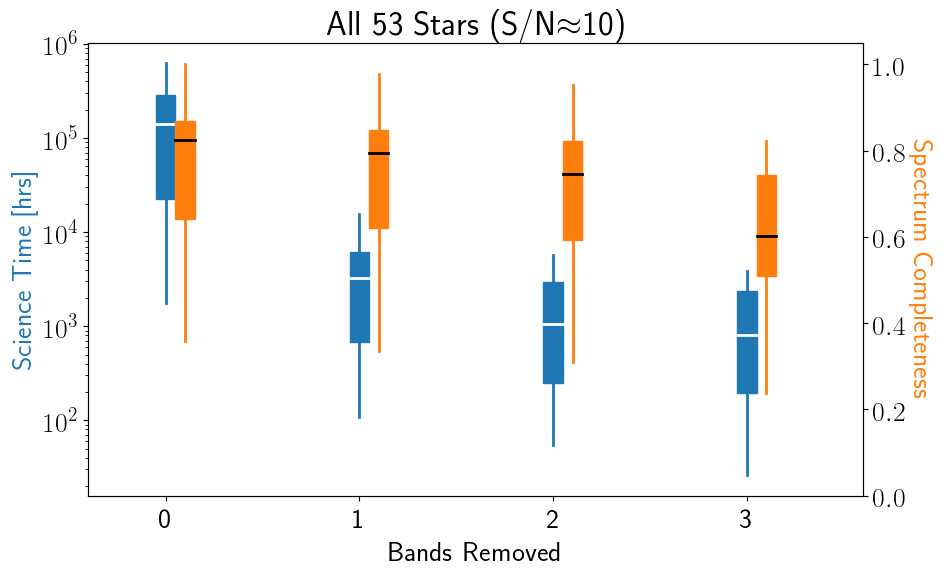

In [20]:
fig2, ax2 = plt.subplots(figsize = (10,6))
ax3 = ax2.twinx()
    
data = [t_tots_N[i,:] for i in range(N+1)]
color1 = "C0"
positions = np.arange(N+1)
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

data = [completeness_N[i,:] for i in range(N+1)]
color2 = "C1"
positions = np.arange(N+1) + 0.1
bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                 whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "k", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)
for patch in bp2['boxes']:
    patch.set_facecolor(color2)
    
ax2.set_ylabel("Science Time [hrs]", color = color1)
ax2.set_title(r"All %i Stars (S/N$\approx$%i)" %(NBIAS, wantSNR))
ax2.set_yscale("log")

ax2.set_xlabel("Bands Removed")
ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
ax3.set_ylim(0.0,1.05)

ax2.set_xticks(np.arange(N+1));
ax2.set_xticklabels(np.arange(N+1));

/Users/Jake/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3768: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


(0.1, 2.0)

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


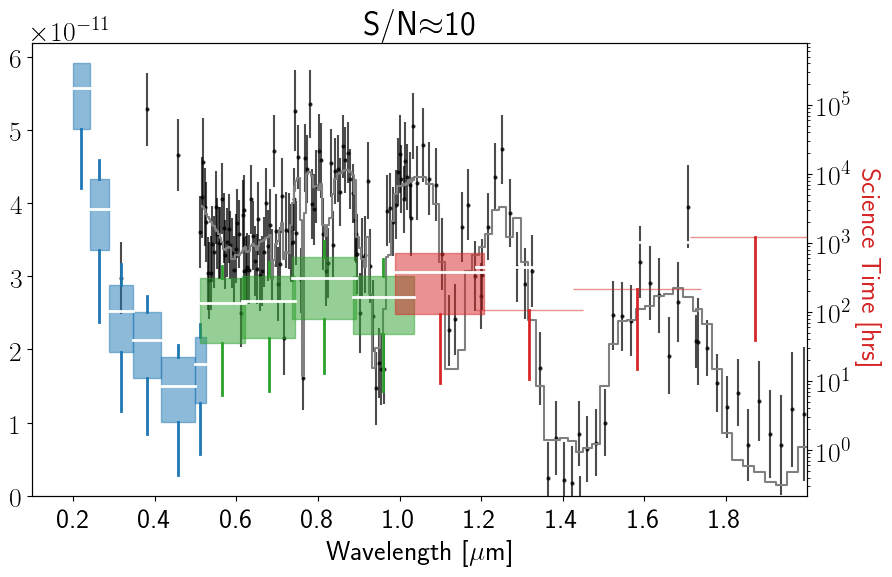

In [21]:
fig, ax = plt.subplots(figsize = (10,6))
cc = ["C0", "C2", "C3"]

ax2 = ax.twinx()

#ax.plot(lamhr, Ahr, c = "k", zorder = 100)
#ax.set_ylim(0.0, 0.1*np.ceil(10*np.max(Ahr[lamhr < 2.0])))
#ax.set_ylabel("Geometric Albedo")

tmp = [np.zeros((len(tpbpcs[0][i]), len(tpbpcs))) for i in range(len(tpbpcs[0]))]
for i in range(len(tpbpcs)):
    for j in range(len(tpbpcs[0])):
        tmp[j][:,i] = tpbpcs[i][j]

icount = 0
for j in range(len(tmp)):
    
    data = []
    positions = []
    widths = []
    for i in range(tmp[j].shape[0]):
        data.append(tmp[j][i,:])
        positions.append(np.mean(specs[0][0][icount]))
        widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0] + np.mean(specs[0][1][icount][:]))
        
        ax.plot(specs[0][0][icount], specs[0][2][icount], ls = "steps-mid", color = "grey", zorder = 100)
        ax.errorbar(specs[0][0][icount], specs[0][3][icount], yerr=specs[0][4][icount], fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
        
        icount += 1
        
    color1 = cc[j]
    positions = np.array(positions)
    widths = np.array(widths)
    bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                      boxprops = {"color" : color1, "alpha" : 0.5}, 
                      whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                      capprops = {"color" : color1, "linewidth" : 0.0}, 
                      medianprops = {"color" : "w", "linewidth" : 2.0}, 
                      patch_artist=True, positions = positions, whis = [5, 95]); 

    for patch in bp1['boxes']:
        patch.set_facecolor(color1)
    
ax2.set_ylabel("Science Time [hrs]", color = color1, rotation = 270, labelpad = 22)
ax2.set_title(r"S/N$\approx$%i" %wantSNR)
ax2.set_yscale("log")

ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylim(bottom = 0.0)

ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
ax2.set_xlim(0.1, 2.0)

In [22]:
Xdraw = 500    # Number for unbiased random samples
Ndraw = 5      # Number of stars to randomly draw from biased sample
Nrem = 1

np.random.seed(seed=None)

# Get index with matching stellar type in stellar properties table
imatches = np.array([spectroscopy.match_stellar_type(biased_sample["stype"][j], verbose = False) for j in range(NBIAS)])

# Allocate memory for exposure times
ctime_tot = np.zeros((Ndraw, Xdraw))
ccomp_tot = np.zeros((Ndraw, Xdraw))

# Loop over number of random draws (for bootstrapping distributions)
for ix in range(Xdraw):
    
    # Randomly draw sample indices
    idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)
    
    # Order systems by "detectability" (sorting must happen at a later step)
    #idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now
    
    # Get the total exposure time and completeness for the selected stars
    ctime_tmp = t_tots_N[Nrem, idraw]
    ccomp_tmp = completeness_N[Nrem, idraw]
    
    # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
    isort = np.argsort(ctime_tmp)
    
    # Set exposure time for this star
    ctime_tot[:, ix] = ctime_tmp[isort]

    # Set completeness for this star
    ccomp_tot[:, ix] = ccomp_tmp[isort]

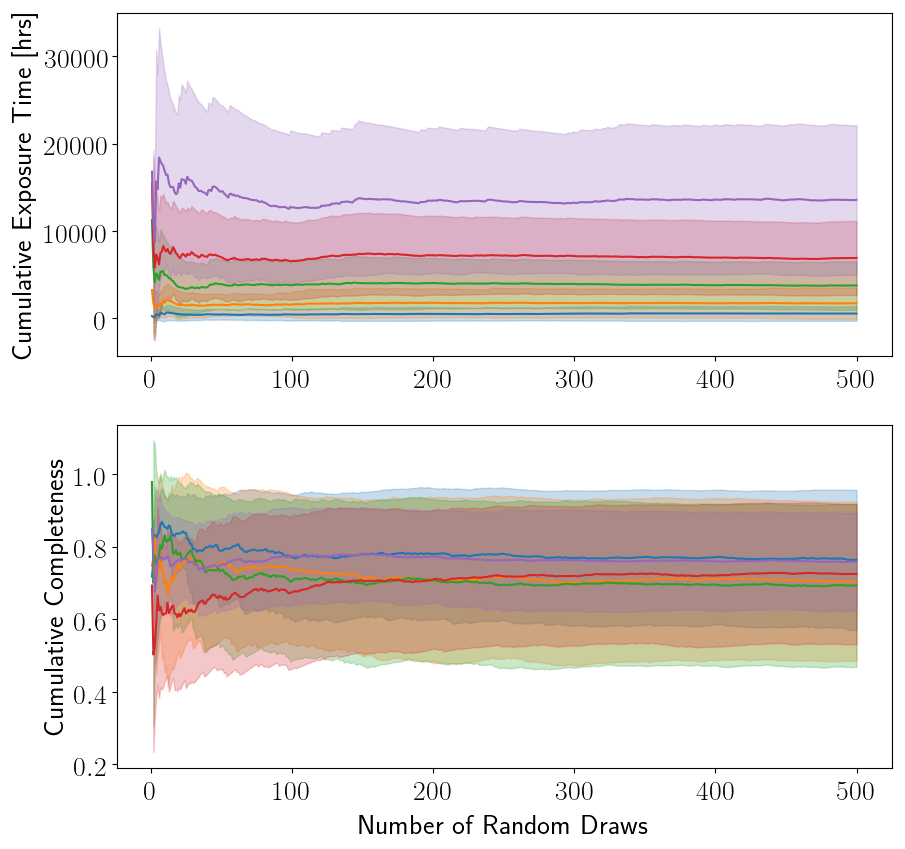

In [23]:
fig, ax = plt.subplots(2, 1, figsize = (10,10))

# Loop over stars in sample
for i in range(Ndraw):
    
    # Calculate the cumulative mean time (to estimate convergence)
    cummean_time = pd.Series(ctime_tot[i,:]).expanding(1).mean().values
    # Calculate the cumulative std deviation 
    cumstd_time = pd.Series(ctime_tot[i,:]).expanding(1).std().values
    
    # Calculate the cumulative mean completeness (to estimate convergence)
    cummean_comp = pd.Series(ccomp_tot[i,:]).expanding(1).mean().values
    # Calculate the cumulative std deviation 
    cumstd_comp = pd.Series(ccomp_tot[i,:]).expanding(1).std().values
    
    # Plot time
    ax[0].plot((np.arange(Xdraw)+1), cummean_time, c = "C%i" %(i%9))
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax[0].fill_between(np.arange(Xdraw)+1, cummean_time - cumstd_time, cummean_time + cumstd_time, alpha = 0.25, color = "C%i" %(i%9))
    ax[0].set_ylabel("Cumulative Exposure Time [hrs]")
    #ax[0].set_title("Full Spectrum")
    
     # Plot completeness
    ax[1].plot((np.arange(Xdraw)+1), cummean_comp, c = "C%i" %(i%9))
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax[1].fill_between(np.arange(Xdraw)+1, cummean_comp - cumstd_comp, cummean_comp + cumstd_comp, alpha = 0.25, color = "C%i" %(i%9))
    ax[1].set_xlabel("Number of Random Draws")
    ax[1].set_ylabel("Cumulative Completeness")

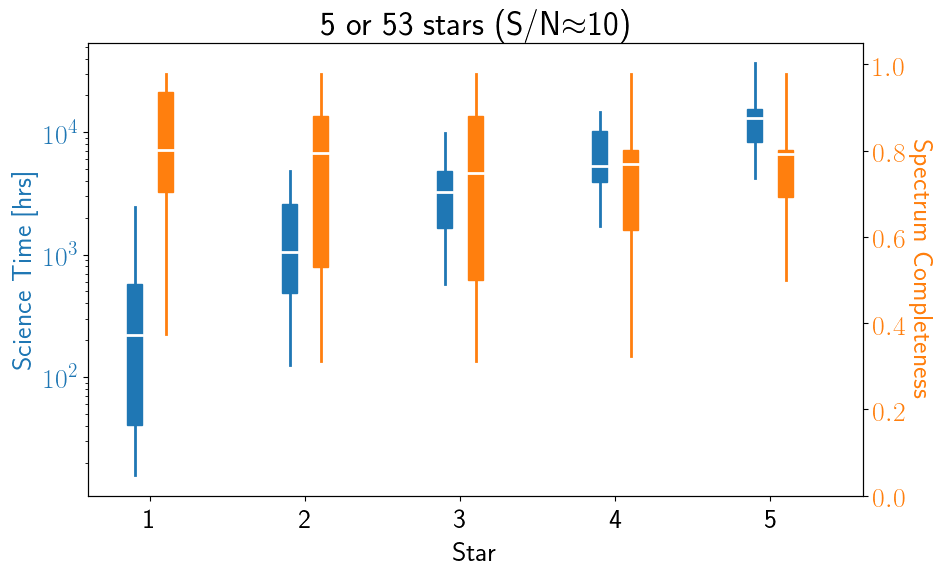

In [24]:
fig2, ax2 = plt.subplots(figsize = (10,6))
ax3 = ax2.twinx()

# Loop over stars in sample
for i in range(Ndraw):

    # Plot time intervals
    #q_l, q_50, q_h, q_m, q_p = nsig_intervals(ctime_tot[i,:], intvls=[0.16, 0.5, 0.84])
    #ax2.errorbar(i+1, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "o", color = "C0")
    
    # Plot completeness intervals
    #q_l, q_50, q_h, q_m, q_p = nsig_intervals(ccomp_tot[i,:], intvls=[0.16, 0.5, 0.84])
    #ax3.errorbar(i+1.05, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "x", color = "C1")
    #ax2[1].set_yscale("log")
    pass
    
data = [ctime_tot[i,:] for i in range(Ndraw)]
color1 = "C0"
positions = np.arange(Ndraw) + 0.9
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

data = [ccomp_tot[i,:] for i in range(Ndraw)]
color2 = "C1"
positions = np.arange(Ndraw) + 1.1
bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                 whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)
for patch in bp2['boxes']:
    patch.set_facecolor(color2)
    
_ = [i.set_color(color1) for i in ax2.get_yticklabels()];
_ = [i.set_color(color2) for i in ax3.get_yticklabels()];
    
ax2.set_ylabel("Science Time [hrs]", color = color1)
ax2.set_title(r"%i or %i stars (S/N$\approx$%i)" %(Ndraw, NBIAS, wantSNR))
ax2.set_yscale("log")

ax2.set_xlabel("Star")
ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
ax3.set_ylim(0.0,1.05)

ax2.set_xticks(np.arange(Ndraw)+1);
ax2.set_xticklabels(np.arange(Ndraw)+1);

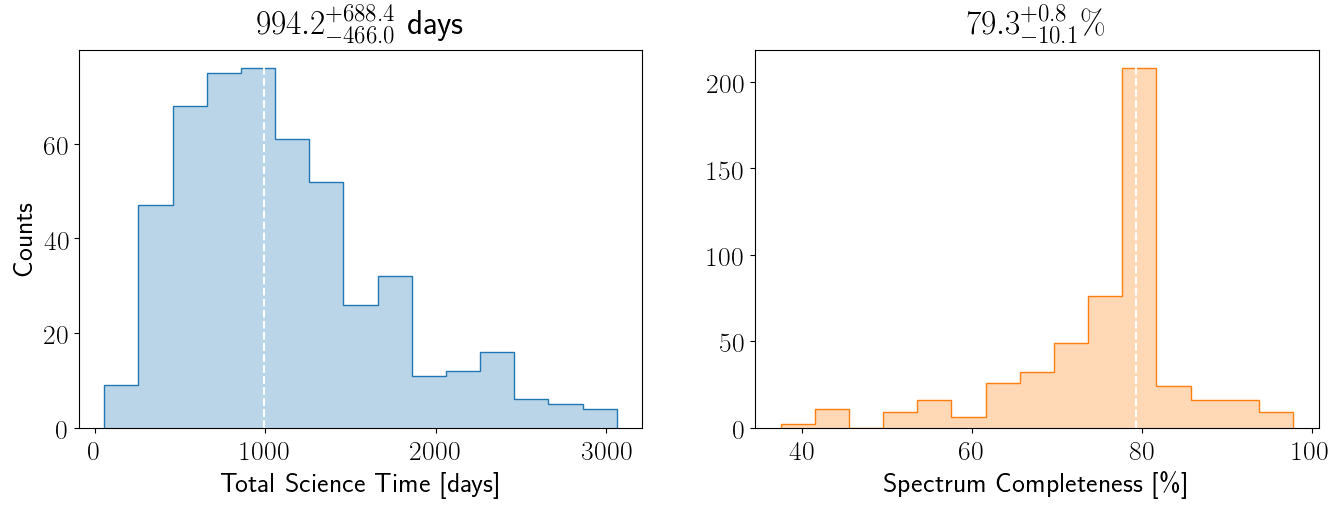

In [25]:
fig4, ax4 = plt.subplots(1, 2, figsize = (16,5))

ctime_sum = np.sum(ctime_tot, axis = 0) / 24.
ctime_med = np.median(ctime_sum)
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)

ax4[0].set_xlabel("Total Science Time [days]")
ax4[0].set_ylabel("Counts")
ax4[0].set_title(result)
ax4[0].hist(ctime_sum, bins = 15, alpha = .3, color = "C0");
ax4[0].hist(ctime_sum, bins = 15, alpha = 1.0, histtype="step", color = "C0");
ax4[0].axvline(ctime_med, color = "w", ls = "dashed")

ccomp_meds = np.median(ccomp_tot, axis = 0) * 100.
ccomp_med = np.median(ccomp_meds)
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ccomp_meds)
result = "$%.1f^{+%.1f}_{-%.1f} \%%$ " %(q_50, q_p, q_m)

ax4[1].set_xlabel("Spectrum Completeness [\%]")
ax4[1].set_title(result)
ax4[1].hist(ccomp_meds, bins = 15, alpha = .3, color = "C1");
ax4[1].hist(ccomp_meds, bins = 15, alpha = 1.0, histtype="step", color = "C1");
ax4[1].axvline(ccomp_med, color = "w", ls = "dashed")

In [26]:
def sample_complete_spectra(t_tots_N, completeness_N, Ndraw = 5, Xdraw = 500, Nrem = 0, 
                            plot_converge = False, plot_stats = True, plot_totals = True):
    """
    Ramdomly sample from catalog of exposure times for all stars in biased sample
    """
    
    #Xdraw = 500    # Number for unbiased random samples
    #Ndraw = 5      # Number of stars to randomly draw from biased sample
    #Nrem = 1
    
    """
    Randomly sample ``Ndraw`` stars ``Xdraw`` number of times
    """

    # Get index with matching stellar type in stellar properties table
    imatches = np.array([spectroscopy.match_stellar_type(biased_sample["stype"][j], verbose = False) for j in range(NBIAS)])

    # Allocate memory for exposure times
    ctime_tot = np.zeros((Ndraw, Xdraw))
    ccomp_tot = np.zeros((Ndraw, Xdraw))

    # Loop over number of random draws (for bootstrapping distributions)
    for ix in range(Xdraw):

        # Randomly draw sample indices
        idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)

        # Order systems by "detectability" (sorting must happen at a later step)
        #idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now

        # Get the total exposure time and completeness for the selected stars
        ctime_tmp = t_tots_N[Nrem, idraw]
        ccomp_tmp = completeness_N[Nrem, idraw]

        # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
        isort = np.argsort(ctime_tmp)

        # Set exposure time for this star
        ctime_tot[:, ix] = ctime_tmp[isort]

        # Set completeness for this star
        ccomp_tot[:, ix] = ccomp_tmp[isort]
        
    """
    Plot cumulative stats to test for stability
    """
    
    if plot_converge:
    
        fig, ax = plt.subplots(2, 1, figsize = (10,10))

        # Loop over stars in sample
        for i in range(Ndraw):

            # Calculate the cumulative mean time (to estimate convergence)
            cummean_time = pd.Series(ctime_tot[i,:]).expanding(1).mean().values
            # Calculate the cumulative std deviation 
            cumstd_time = pd.Series(ctime_tot[i,:]).expanding(1).std().values

            # Calculate the cumulative mean completeness (to estimate convergence)
            cummean_comp = pd.Series(ccomp_tot[i,:]).expanding(1).mean().values
            # Calculate the cumulative std deviation 
            cumstd_comp = pd.Series(ccomp_tot[i,:]).expanding(1).std().values

            # Plot time
            ax[0].plot((np.arange(Xdraw)+1), cummean_time, c = "C%i" %(i%9))
            #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
            ax[0].fill_between(np.arange(Xdraw)+1, cummean_time - cumstd_time, cummean_time + cumstd_time, alpha = 0.25, color = "C%i" %(i%9))
            ax[0].set_ylabel("Cumulative Exposure Time [hrs]")
            #ax[0].set_title("Full Spectrum")

             # Plot completeness
            ax[1].plot((np.arange(Xdraw)+1), cummean_comp, c = "C%i" %(i%9))
            #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
            ax[1].fill_between(np.arange(Xdraw)+1, cummean_comp - cumstd_comp, cummean_comp + cumstd_comp, alpha = 0.25, color = "C%i" %(i%9))
            ax[1].set_xlabel("Number of Random Draws")
            ax[1].set_ylabel("Cumulative Completeness")
            
    
    """
    Plot statistics
    """
    if plot_stats:
    
        fig2, ax2 = plt.subplots(figsize = (10,6))
        ax3 = ax2.twinx()

        data = [ctime_tot[i,:] for i in range(Ndraw)]
        color1 = "C0"
        positions = np.arange(Ndraw) + 0.9
        bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                         whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                         patch_artist=True, positions = positions, whis = [5, 95]); 

        data = [ccomp_tot[i,:] for i in range(Ndraw)]
        color2 = "C1"
        positions = np.arange(Ndraw) + 1.1
        bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                         whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                         patch_artist=True, positions = positions, whis = [5, 95]); 

        for patch in bp1['boxes']:
            patch.set_facecolor(color1)
        for patch in bp2['boxes']:
            patch.set_facecolor(color2)

        _ = [i.set_color(color1) for i in ax2.get_yticklabels()];
        _ = [i.set_color(color2) for i in ax3.get_yticklabels()];

        ax2.set_ylabel("Science Time [hrs]", color = color1)
        ax2.set_title(r"%i or %i stars (S/N$\approx$%i)" %(Ndraw, NBIAS, wantSNR))
        ax2.set_yscale("log")

        ax2.set_xlabel("Star")
        ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
        ax3.set_ylim(0.0,1.05)
        
        ax2.set_xticks(np.arange(Ndraw)+1);
        ax2.set_xticklabels(np.arange(Ndraw)+1);
        
    if plot_totals:
        
        fig4, ax4 = plt.subplots(1, 2, figsize = (16,5))

        # Plot exposure time hist
        ctime_sum = np.sum(ctime_tot, axis = 0) / 24.
        ctime_med = np.median(ctime_sum)
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
        result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
        ax4[0].set_xlabel("Total Science Time [days]")
        ax4[0].set_ylabel("Counts")
        ax4[0].set_title(result)
        ax4[0].hist(ctime_sum, bins = 15, alpha = .3, color = "C0");
        ax4[0].hist(ctime_sum, bins = 15, alpha = 1.0, histtype="step", color = "C0");
        ax4[0].axvline(ctime_med, color = "w", ls = "dashed")

        # Plot completeness hist
        ccomp_meds = np.median(ccomp_tot, axis = 0) * 100.
        ccomp_med = np.median(ccomp_meds)
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ccomp_meds)
        result = "$%.1f^{+%.1f}_{-%.1f} \%%$ " %(q_50, q_p, q_m)
        ax4[1].set_xlabel("Spectrum Completeness [\%]")
        ax4[1].set_title(result)
        ax4[1].hist(ccomp_meds, bins = 15, alpha = .3, color = "C1");
        ax4[1].hist(ccomp_meds, bins = 15, alpha = 1.0, histtype="step", color = "C1");
        ax4[1].axvline(ccomp_med, color = "w", ls = "dashed")
    
    return 

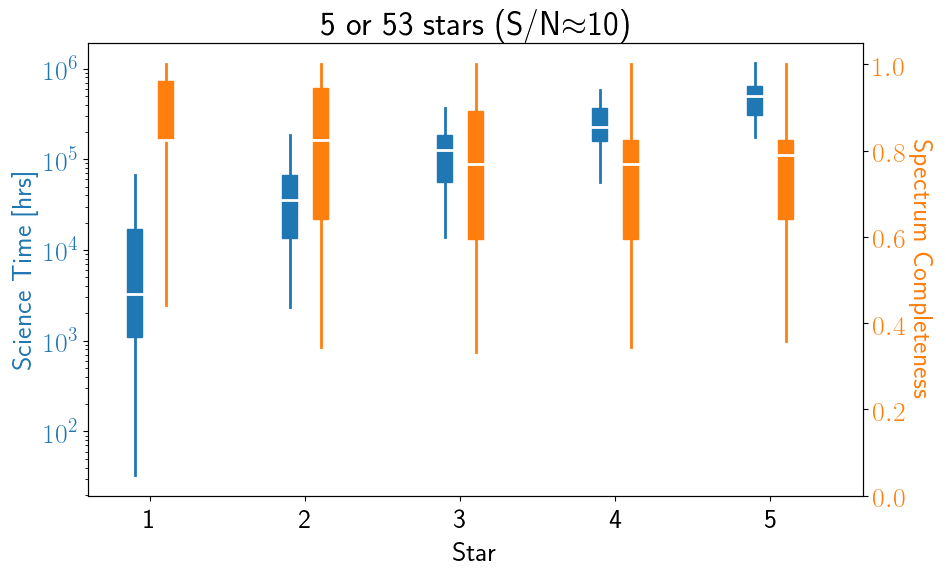

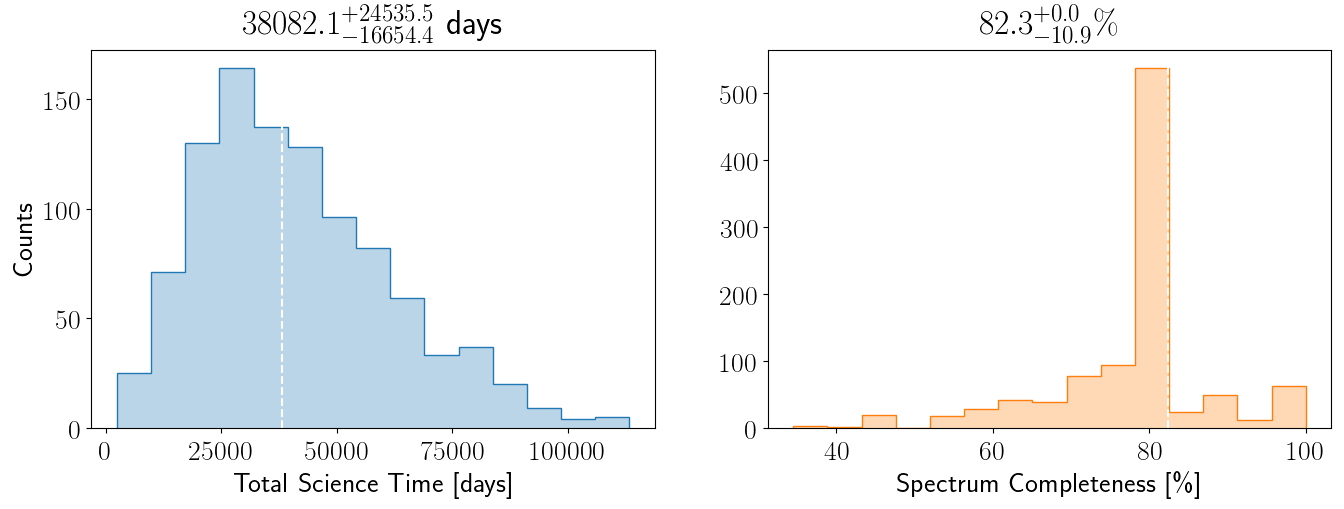

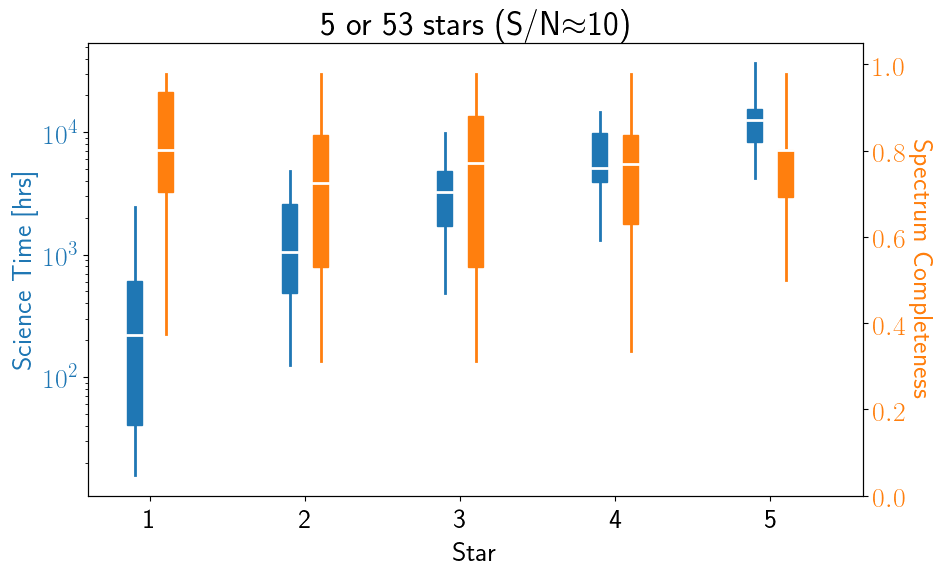

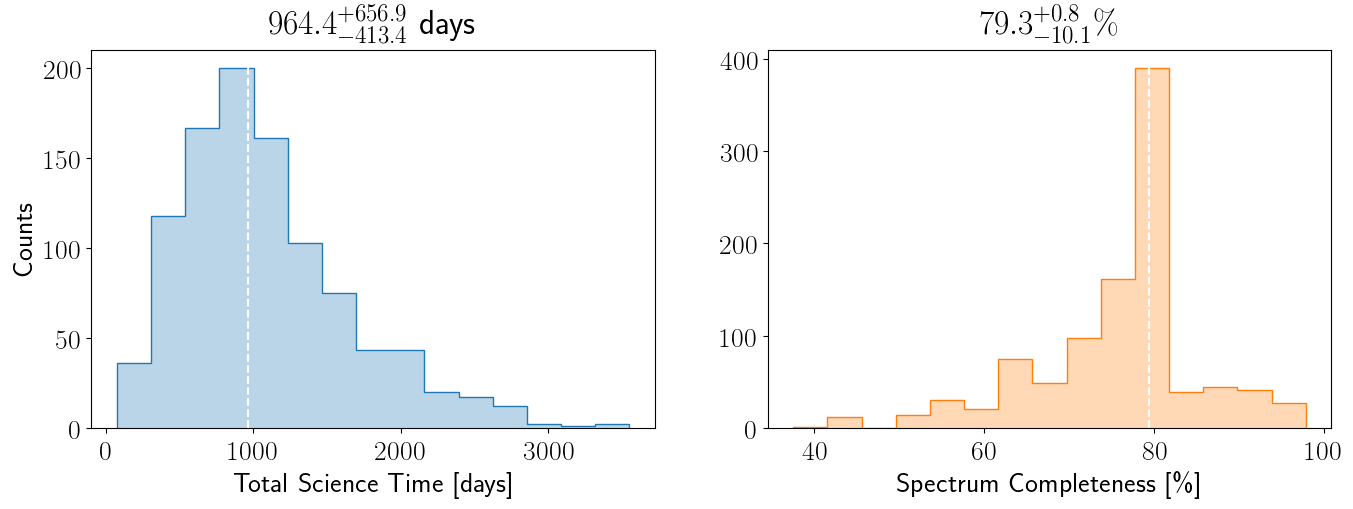

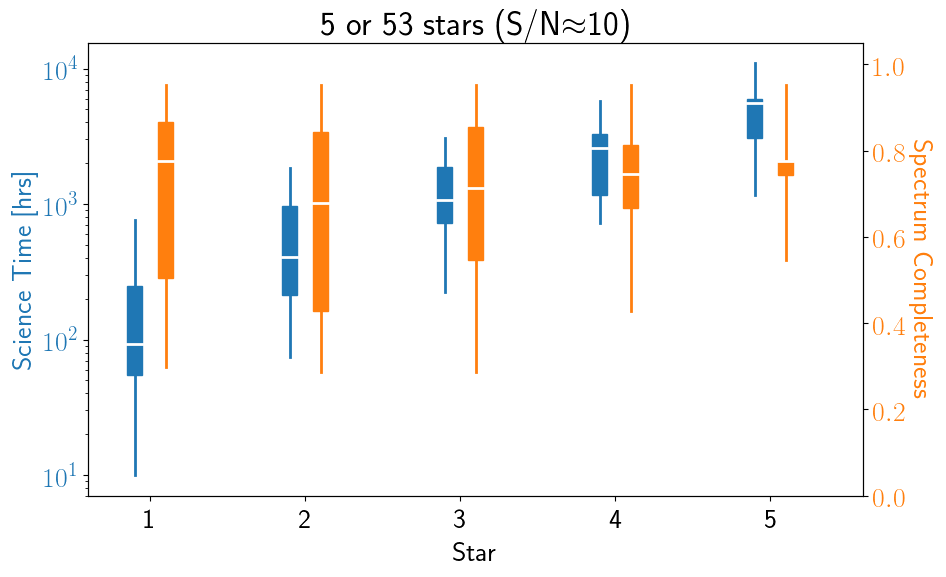

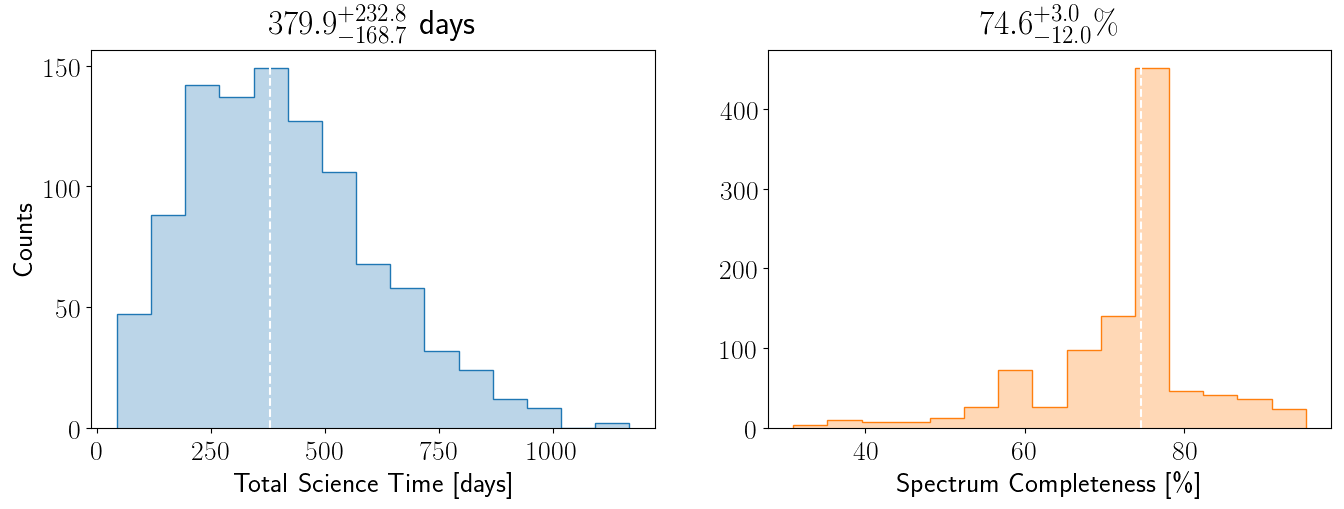

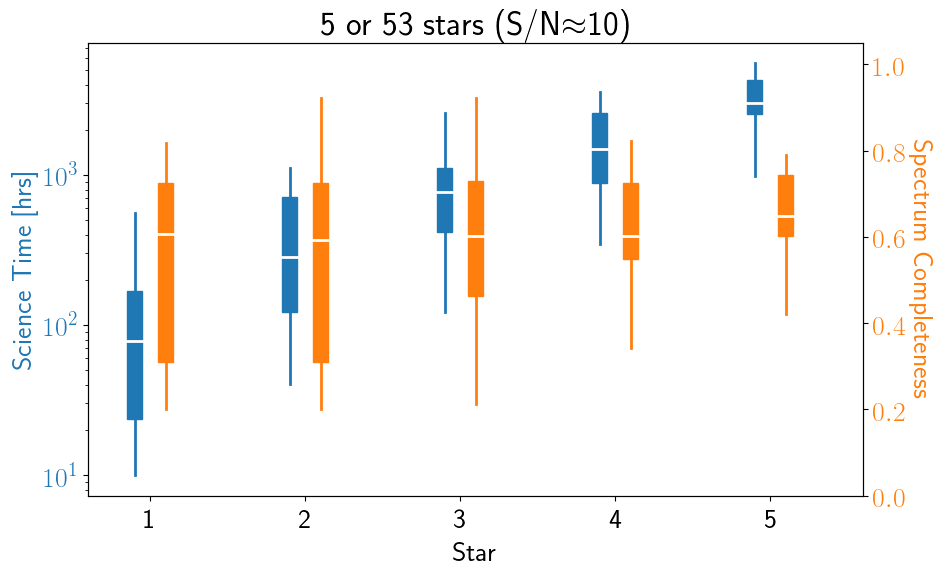

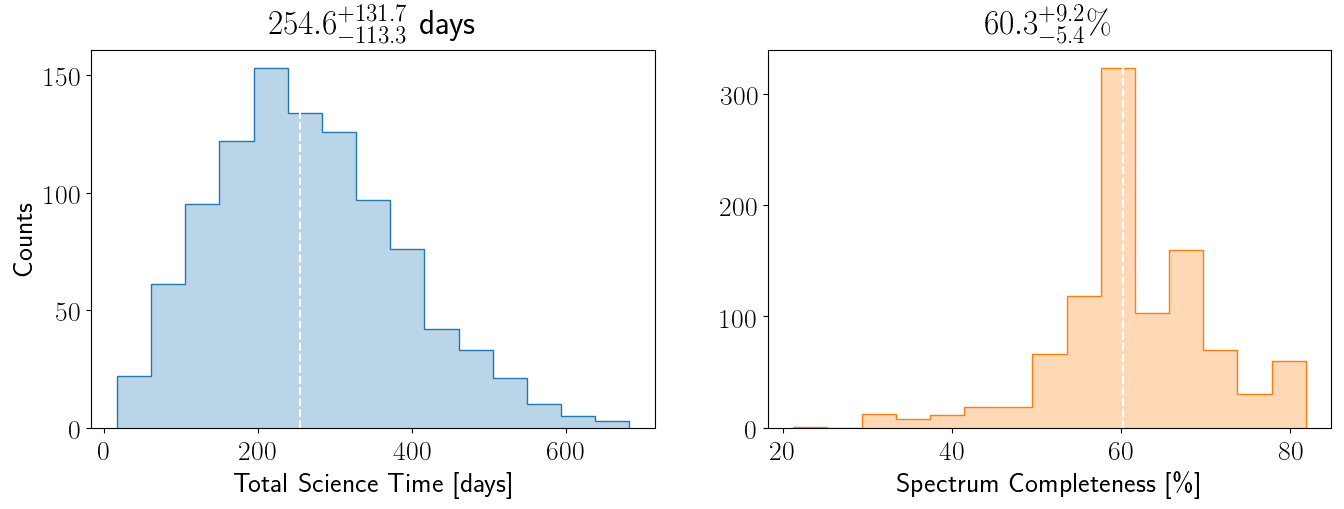

In [27]:
np.random.seed(seed=None)
Xdraw = 1000
Ndraw = 5     # of 58

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 0, 
                        plot_converge = False, plot_stats = True)

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 1, 
                        plot_converge = False, plot_stats = True)

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 2, 
                        plot_converge = False, plot_stats = True)

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 3, 
                        plot_converge = False, plot_stats = True)

# Calculate Randomly Sampled Exposure Times for Each Bandpass

In [28]:
tpbpcs_draws_stars = []
tpbpcs_draws_tots = []
comp_draws_stars = []

for ichan in range(len(spectroscopy.CHANNELS)):
    
    tpbpcs_draws_stars.append([])
    tpbpcs_draws_tots.append([])
    comp_draws_stars.append([])
        
    for iband in range(len(tpbpcs[0][ichan])):
                
        samples = np.zeros((Ndraw, Xdraw))
        for ix in range(Xdraw):
            
            # Randomly draw sample indices
            idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)
            
            # Get exptimes for each star drawn
            tmp_draws = np.array([tpbpcs[idrew][ichan][iband] for idrew in idraw])
            
            # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
            isort = np.argsort(tmp_draws)
            
            # Apply sorting
            samples[:,ix] = tmp_draws[isort]
        
        # Make infs --> nans
        infmask = ~np.isfinite(samples)
        samples[infmask] = np.nan
        
        # Count completeness factor
        comp_samples = np.copy(samples)
        comp_samples[infmask] = 0.0
        comp_samples[~infmask] = 1.0
        comp_count = np.sum(comp_samples, axis = 1) / Xdraw
        
        # Calculate medians for each star
        mps = np.nanmedian(samples, axis=1)
        print("%s channel, band %i:" %(spectroscopy.CHANNELS[ichan], iband+1))
        print(mps)
        print(comp_count)
        
        # Calculate the median total exptime
        x = np.nansum(samples, axis=0)
        
        tpbpcs_draws_stars[ichan].append(samples)
        tpbpcs_draws_tots[ichan].append(x)
        comp_draws_stars[ichan].append(comp_count)

UV channel, band 1:
[ 13635.36653795  63723.90165311 177454.42365043 312977.86203688
 491967.9729133 ]
[1.    1.    0.998 0.942 0.604]
UV channel, band 2:
[  210.10853962  1241.05363869  3056.55615767  5122.06857191
 13903.76274531]
[1.    1.    1.    1.    0.899]
UV channel, band 3:
[  7.24513823  51.01663227 103.18887851 168.14184048 442.90121451]
[1. 1. 1. 1. 1.]
UV channel, band 4:
[  2.85872307  19.8527099   39.51937645  81.55430059 158.42160206]
[1. 1. 1. 1. 1.]
UV channel, band 5:
[ 0.70549391  3.99264853  8.37057494 17.00860318 29.47701172]
[1. 1. 1. 1. 1.]
UV channel, band 6:
[ 1.43299883  7.28552159 16.82769471 24.02977311 56.30114347]
[1. 1. 1. 1. 1.]
vis channel, band 1:
[ 12.19988062  54.10663352 135.09459915 260.27780733 446.21699952]
[1. 1. 1. 1. 1.]
vis channel, band 2:
[ 13.9257379   57.09996957 140.47747048 278.07571802 479.15510202]
[1. 1. 1. 1. 1.]
vis channel, band 3:
[ 28.73212593 114.19071997 311.41046659 482.01190355 903.58369206]
[1.   1.   1.   1.   0.92]
vis 

## Plot the total exposure time for all eta_interesting stars in sample

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(0.1, 2.0)

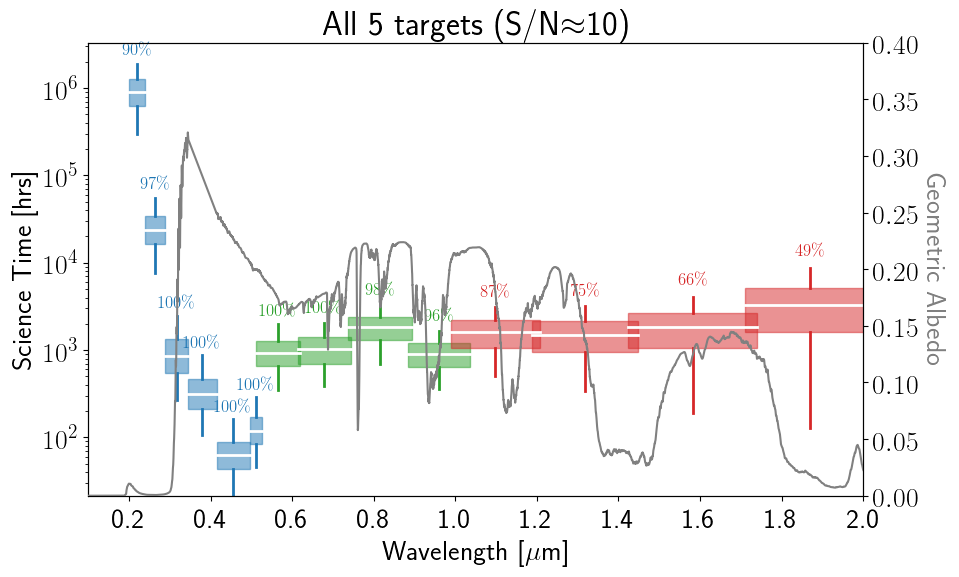

In [29]:
fig, ax2 = plt.subplots(figsize = (10,6))
cc = ["C0", "C2", "C3"]

ax = ax2.twinx()

ax.plot(lamhr, Ahr, c = "grey", zorder = 100)
ax.set_ylim(0.0, 0.1*np.ceil(10*np.max(Ahr[lamhr < 2.0])))
ax.set_ylabel("Geometric Albedo", rotation = 270, labelpad = 22, color = "grey")

# Transform quantities for boxplot
tmp = [np.zeros((len(tpbpcs_draws_tots[i]), Xdraw)) for i in range(len(spectroscopy.CHANNELS))]
for i in range(Xdraw):
    for j in range(len(tpbpcs_draws_tots)):
        for k in range(len(tpbpcs_draws_tots[j])):
            tmp[j][k,i] = tpbpcs_draws_tots[j][k][i]

icount = 0
for j in range(len(tmp)):
    
    data = []
    positions = []
    widths = []
    for i in range(tmp[j].shape[0]):
        data.append(tmp[j][i,:])
        positions.append(np.mean(specs[0][0][icount]))
        widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0] + np.mean(specs[0][1][icount][:]))
        
        comp_str = "$%i \%%$" %(100.*np.mean(comp_draws_stars[j][i]))
        ax2.text(positions[i], np.median(tmp[j][i,:]) + 5.*np.std(tmp[j][i,:]), comp_str, 
                 ha = "center", va = "top", fontsize = 12, color = cc[j])
        
        #ax.plot(specs[0][0][icount], specs[0][1][icount], ls = "steps-mid", color = "grey", zorder = 100)
        #ax.errorbar(specs[0][0][icount], specs[0][2][icount], yerr=specs[0][3][icount], fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
        
        icount += 1
        
    color1 = cc[j]
    positions = np.array(positions)
    widths = np.array(widths)
    bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                      boxprops = {"color" : color1, "alpha" : 0.5}, 
                      whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                      capprops = {"color" : color1, "linewidth" : 0.0}, 
                      medianprops = {"color" : "w", "linewidth" : 2.0}, 
                      patch_artist=True, positions = positions, whis = [5, 95]); 

    for patch in bp1['boxes']:
        patch.set_facecolor(color1)
    
ax2.set_ylabel("Science Time [hrs]")
ax2.set_title(r"All %i targets (S/N$\approx$%i)" %(Ndraw, wantSNR))
ax2.set_yscale("log")

ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylim(bottom = 0.0)

ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax2.set_xlim(0.1, 2.0)

## Plot the exposure time and completeness in each band for randomly sampled stars

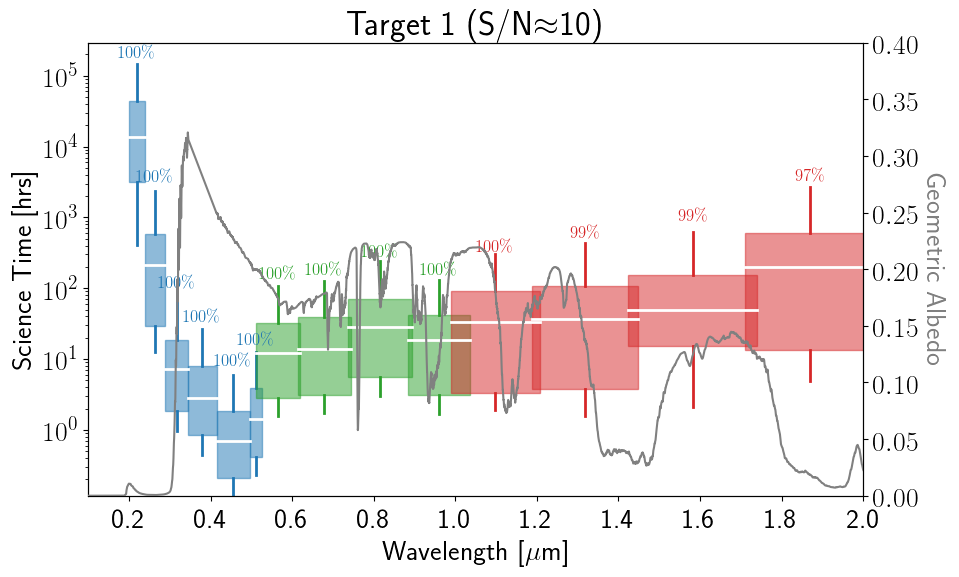

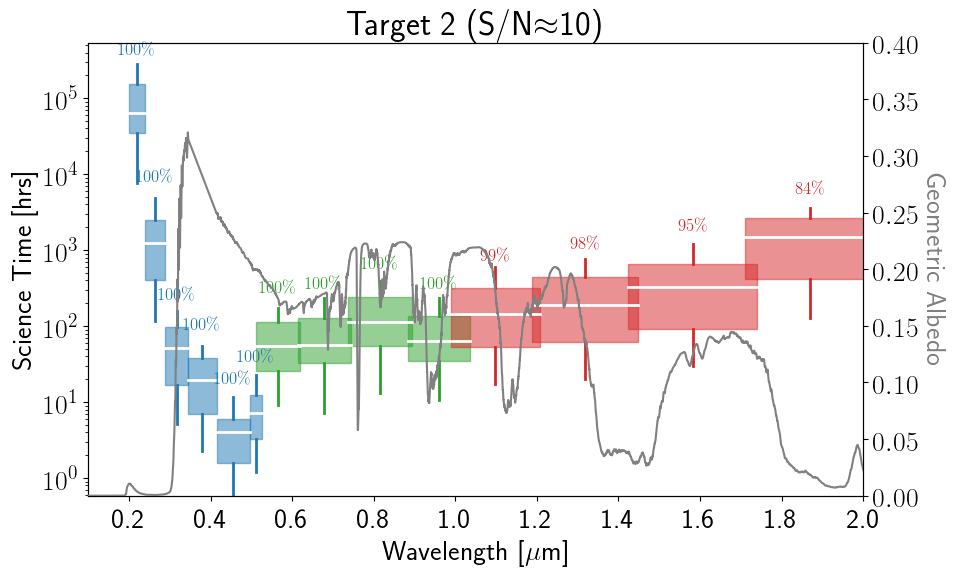

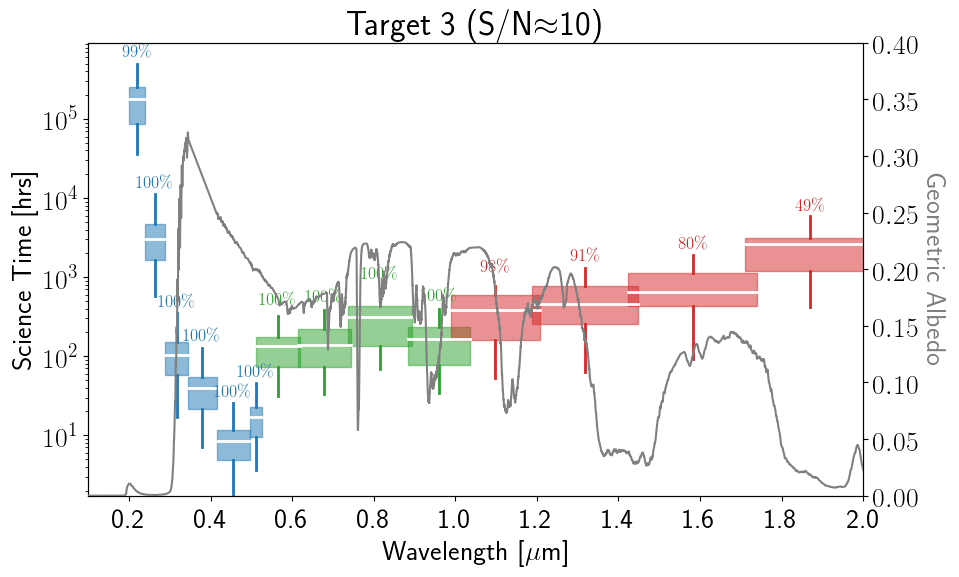

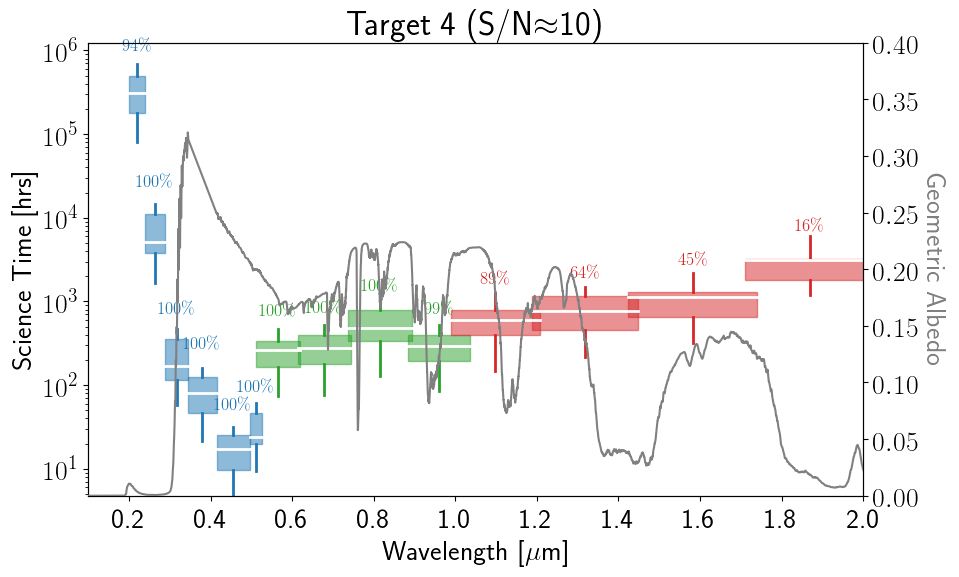

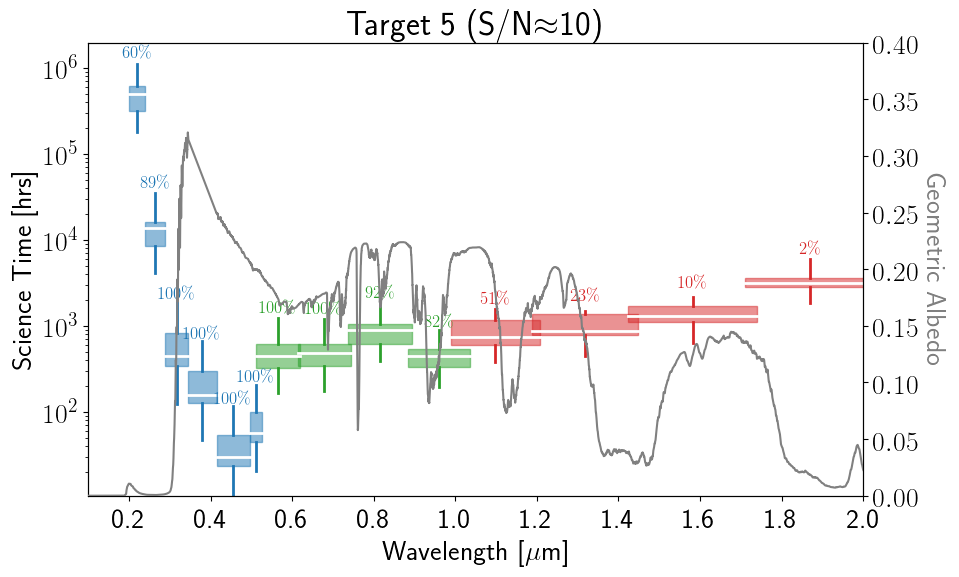

In [30]:
for itarget in range(Ndraw):
    
    fig, ax2 = plt.subplots(figsize = (10,6))
    cc = ["C0", "C2", "C3"]

    ax = ax2.twinx()

    ax.plot(lamhr, Ahr, c = "grey", zorder = 100)
    ax.set_ylim(0.0, 0.1*np.ceil(10*np.max(Ahr[lamhr < 2.0])))
    ax.set_ylabel("Geometric Albedo", rotation = 270, labelpad = 22, color = "grey")

    # Transform quantities for boxplot
    tmp = [np.zeros((len(tpbpcs_draws_stars[i]), Xdraw)) for i in range(len(spectroscopy.CHANNELS))]
    for i in range(Xdraw):
        for j in range(len(tpbpcs_draws_stars)):
            for k in range(len(tpbpcs_draws_stars[j])):
                tmp[j][k,i] = tpbpcs_draws_stars[j][k][itarget, i]

    icount = 0
    for j in range(len(tmp)):

        data = []
        positions = []
        widths = []
        for i in range(tmp[j].shape[0]):
            nans = np.isnan(tmp[j][i,:])
            data.append(tmp[j][i,~nans])
            positions.append(np.mean(specs[0][0][icount]))
            widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0] + np.mean(specs[0][1][icount][:]))

            comp_str = r"$%i \%%$" %(100.*comp_draws_stars[j][i][itarget])
            ax2.text(positions[i], np.nanmedian(tmp[j][i,:]) + 5.*np.nanstd(tmp[j][i,:]), comp_str, 
                     ha = "center", va = "top", fontsize = 12, color = cc[j])

            #ax.plot(specs[0][0][icount], specs[0][1][icount], ls = "steps-mid", color = "grey", zorder = 100)
            #ax.errorbar(specs[0][0][icount], specs[0][2][icount], yerr=specs[0][3][icount], fmt = "o", ms = 2.0, alpha = 0.7, color = "k")

            icount += 1

        color1 = cc[j]
        positions = np.array(positions)
        widths = np.array(widths)
        bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                          boxprops = {"color" : color1, "alpha" : 0.5}, 
                          whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                          capprops = {"color" : color1, "linewidth" : 0.0}, 
                          medianprops = {"color" : "w", "linewidth" : 2.0}, 
                          patch_artist=True, positions = positions, whis = [5, 95]); 

        for patch in bp1['boxes']:
            patch.set_facecolor(color1)

    ax2.set_ylabel("Science Time [hrs]")
    ax2.set_title(r"Target %i (S/N$\approx$%i)" %(itarget+1, wantSNR))
    ax2.set_yscale("log")

    ax2.set_xlabel("Wavelength [$\mu$m]")
    ax2.set_ylim(bottom = 0.0)

    ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    ax2.set_xlim(0.1, 2.0)

## Make a Lookup Table of Exposure times for each star in sample

In [69]:
tpbpcs_rect = []    # Time per bandpass 
tpcs_rect = []      # Time per channel 

for idrew in range(NBIAS):
    
    tpbpcs_rect.append([])
    tpcs_rect.append([])
    bp_names = []
    bp_chan = []

    for ichan in range(len(spectroscopy.CHANNELS)):
        
        tpcs_rect[idrew].append(0.0)

        for iband in range(len(tpbpcs[0][ichan])):
            
            bp_names.append("%s %i" %(spectroscopy.CHANNELS[ichan], iband+1))
            bp_chan.append(ichan)
            tpbpcs_rect[idrew].append(tpbpcs[idrew][ichan][iband])
            tpcs_rect[idrew][ichan] += tpbpcs[idrew][ichan][iband]
        
tpbpcs_rect = np.array(tpbpcs_rect)
tpcs_rect = np.array(tpcs_rect)
bp_names = np.array(bp_names)
bp_chan = np.array(bp_chan)

# Make infs --> nans
infmask = ~np.isfinite(tpbpcs_rect)
tpbpcs_rect[infmask] = np.nan
infmask = ~np.isfinite(tpcs_rect)
tpcs_rect[infmask] = np.nan

In [32]:
data = np.vstack([biased_sample["hip"], 
                  biased_sample["stype"], 
                  biased_sample["dist"], 
                  tpbpcs_rect.T])
columns = np.hstack(["HIP", "type", "d [pc]", bp_names])

isort = np.argsort(tpbpcs_rect[:,6])

table = pd.DataFrame(data[:, isort].T, columns=columns)
table

,HIP,type,d [pc],UV 1,UV 2,UV 3,UV 4,UV 5,UV 6,vis 1,vis 2,vis 3,vis 4,NIR 1,NIR 2,NIR 3,NIR 4
0,91772,K5,3.49174,403.85821826851975,12.699480535086328,0.9535182922340177,0.4390817909206491,0.11730526099701144,0.23347445605984937,1.5631582041876615,1.7330239265986114,3.0418482288201045,1.6870881211199547,1.4040420596218681,1.5470304631272174,2.0808748978731404,4.954092002200963
1,8102,G8V,3.65017,nan,29.691318191252897,1.833741216553983,0.8405425031616691,0.20644903250347196,0.40990342367188276,2.66780692638135,2.898061266672585,4.892872711029115,2.62278414322796,1.8851458573243463,1.997551479073501,2.592189731262365,6.0085756857272115
2,85523,K5,4.5405,1065.2010295851899,26.2099440530457,1.6757591239935292,0.759642062492483,0.20134591690536674,0.40319528702105556,2.791711920061053,3.1189251627472228,5.617450651515616,3.109258447575949,3.3399070247061786,3.793901000942172,5.3031697207017725,13.355830341876029
3,99461,K2V,6.01504,3209.1509227008587,70.97300517497587,3.7160211424711656,1.6818364736580425,0.4329687979208522,0.8797477032452939,6.303738711729166,7.095580659354842,12.994480680909092,7.07216805142865,9.256985299894241,10.64931319140955,15.172962573942003,39.55402983025537
4,12114,K3V,7.1803,6245.527066197601,116.09596301802394,5.205433670339674,2.2856769237712355,0.5863993192907795,1.2011001489856599,9.083686796748575,10.335372490203072,19.64171301862314,10.705459370308132,17.397516619223712,20.382293656310484,29.610647425005855,nan
5,113283,K4Vp,7.60919,7779.346332305371,136.31194730110624,5.744554669267236,2.4868423608653223,0.6386137352712783,1.3146877463779332,10.20045026312261,11.701299122330786,22.670487227511583,12.43753297528165,21.565851303206397,25.422233808147595,37.14062584517913,nan
6,84720,M0V,8.80204,13635.366537947864,210.1085396243326,7.24513822841176,2.8587230689055185,0.7054939120261212,1.4329988252823413,12.199880617649393,13.9257379003257,28.732125928477906,nan,nan,nan,nan,nan
7,32984,K3V,8.71004,13251.307679044008,221.32864105108047,8.349754516799836,3.5569669516140614,0.8979575121148013,1.8643092147300442,14.995449929475207,17.266949179168282,33.99886473028186,18.4720350527645,35.83145306372164,42.436587372621176,nan,nan
8,57939,G8Vp,9.09174,16787.59093547206,343.7833333573876,13.692303405609497,5.912195728060331,1.4139481027044225,2.894405063188632,21.923975641434197,24.651889989288332,46.34971289471406,24.52016462314396,43.272630968221875,50.61722862434772,73.7424655678013,199.05589803901174
9,56997,G8Vvar,9.61169,20745.135591938986,409.244598961688,15.666223449288053,6.717102004881271,1.6011702248979125,3.2900121521735466,25.345581605503405,28.598128679670488,54.30999949948098,28.697968750327146,53.313611345961235,62.56430239867642,91.4569727223371,nan


## How many stars can we get complete spectra for in a specified amount of observing time?

In [33]:
def count_star_wantexp(wantexp = 365. * 24., Ndraw = 5, Xdraw = 500):
    """
    Determine the number of stars that can be observed in a given exposure time. 
    
    Parameters
    ----------
    wantexp : float
        Total exposure time [hours]
    """
    
    ichan = 1
    iband = 0
    
    Ns = np.zeros(Xdraw)
    texps = np.zeros(Xdraw)
    
    for ix in range(Xdraw):
        
        # Randomly draw sample indices
        idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)

        # Get exptimes for each star drawn
        tmp_draws = np.array([t_tots_N[0,idrew] for idrew in idraw])

        # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
        isort = np.argsort(tmp_draws)
        
        tmp_draws = tmp_draws[isort]
        
        texp = 0.0
        iN = 0
        
        while ((texp+tmp_draws[iN]) < wantexp) and (iN < Ndraw):
            
            texp += tmp_draws[iN]
            iN += 1
            
        Ns[ix] = iN
        texps[ix] = texp
    
    return Ns, texps

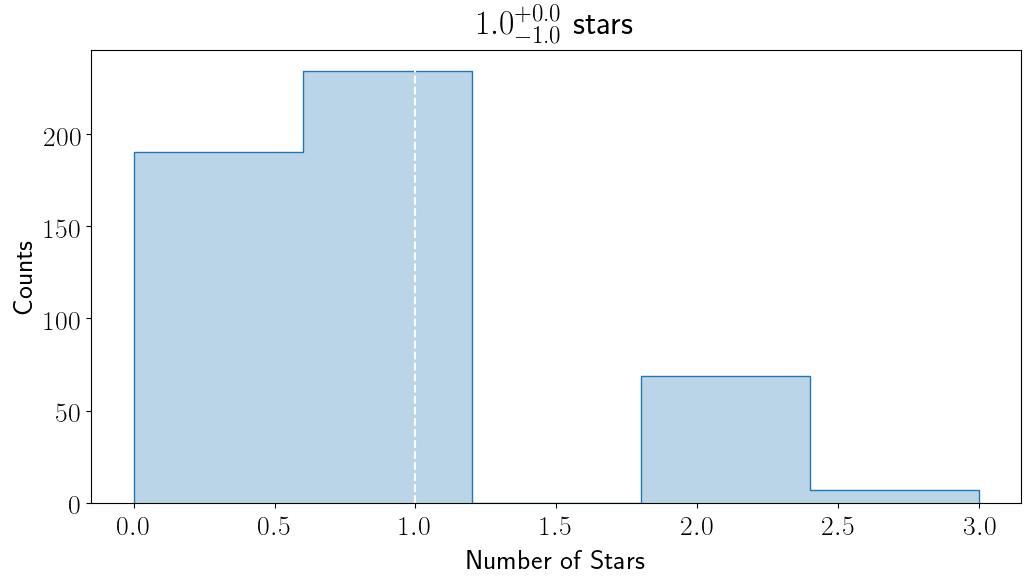

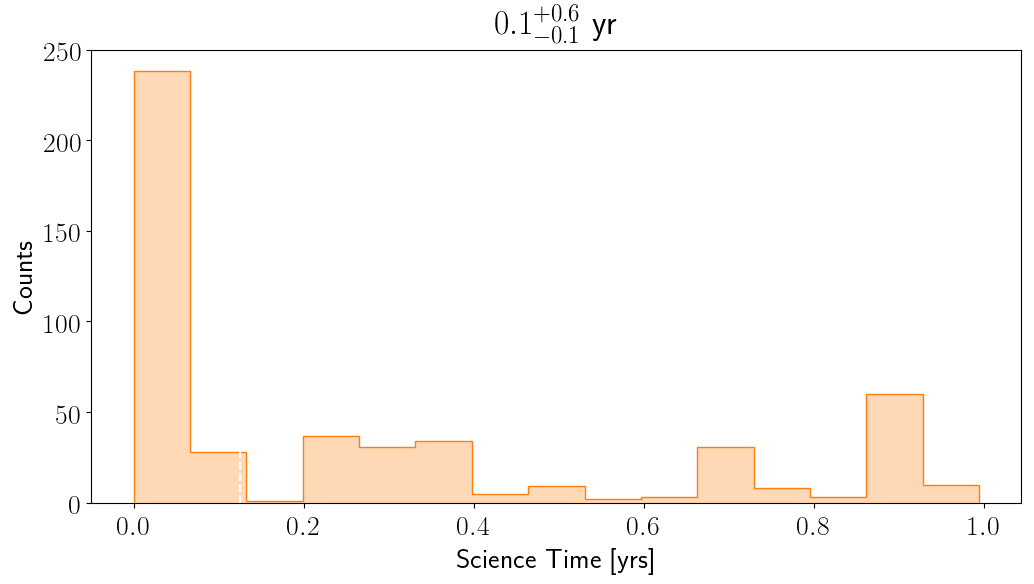

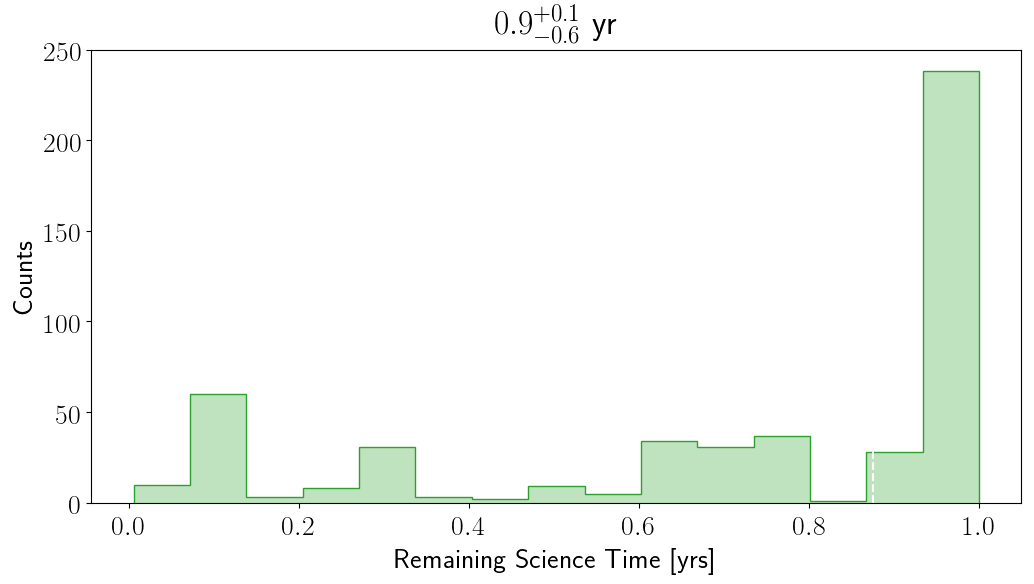

In [34]:
wantexp_yr = 1.0
wantexp_hr = 365. * 24. * wantexp_yr

num_stars, texps = count_star_wantexp(wantexp = wantexp_hr)

texps_yr = texps / (365. * 24.)

# Plot exposure time hist
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(num_stars)
result = "$%.1f^{+%.1f}_{-%.1f}$ stars" %(q_50, q_p, q_m)
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel("Number of Stars")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(num_stars, bins = 5, alpha = .3, color = "C0");
ax.hist(num_stars, bins = 5, alpha = 1.0, histtype="step", color = "C0");
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot exposure time hist
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(texps_yr)
result = "$%.1f^{+%.1f}_{-%.1f}$ yr" %(q_50, q_p, q_m)
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel("Science Time [yrs]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(texps_yr, bins = 15, alpha = .3, color = "C1");
ax.hist(texps_yr, bins = 15, alpha = 1.0, histtype="step", color = "C1");
ax.axvline(q_50, color = "w", ls = "dashed")

# Plot exposure time hist
texps_yr_remain = wantexp_yr - texps_yr
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(texps_yr_remain)
result = "$%.1f^{+%.1f}_{-%.1f}$ yr" %(q_50, q_p, q_m)
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel("Remaining Science Time [yrs]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(texps_yr_remain, bins = 15, alpha = .3, color = "C2");
ax.hist(texps_yr_remain, bins = 15, alpha = 1.0, histtype="step", color = "C2");
ax.axvline(q_50, color = "w", ls = "dashed")

In [35]:
Xdraw = 500
eta_interesting = np.linspace(0.1, 1.0, 100)
ns_eta = np.zeros((len(eta_interesting), Xdraw))
texps_eta = np.zeros((len(eta_interesting), Xdraw))

for i, e_i in enumerate(eta_interesting):

    Nd = int(np.floor(e_i * NBIAS))
    
    ns_eta[i,:], texps_eta[i,:] = count_star_wantexp(wantexp = wantexp_hr, Ndraw = Nd, Xdraw = Xdraw)

(0.0, 5.2)

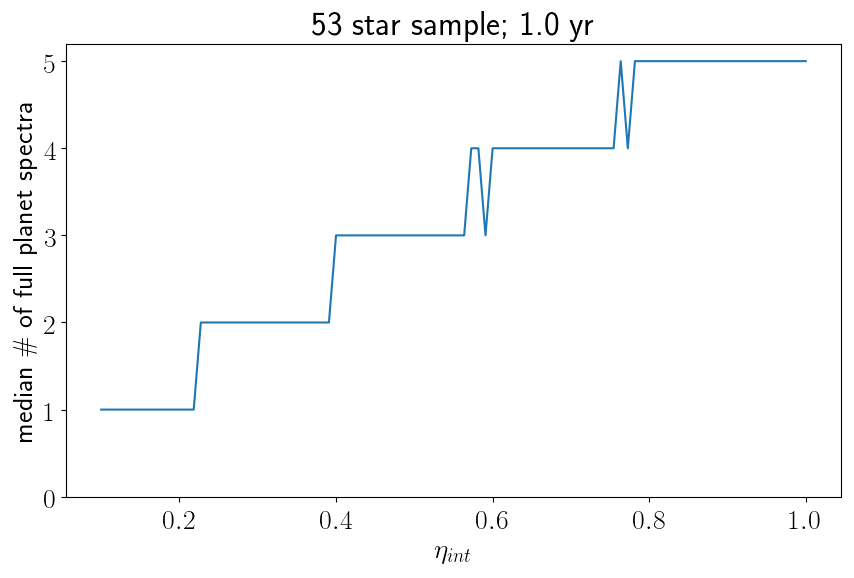

In [36]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_xlabel("$\eta_{int}$")
ax.set_ylabel("median \# of full planet spectra")
ax.set_title("%i star sample; %.1f yr" %(NBIAS, wantexp_yr))
#ax.errorbar(eta_interesting, np.median(ns_eta, axis = 1), yerr=np.std(ns_eta, axis = 1))
ax.plot(eta_interesting, np.median(ns_eta, axis = 1))
ax.set_ylim(bottom=0.0)

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


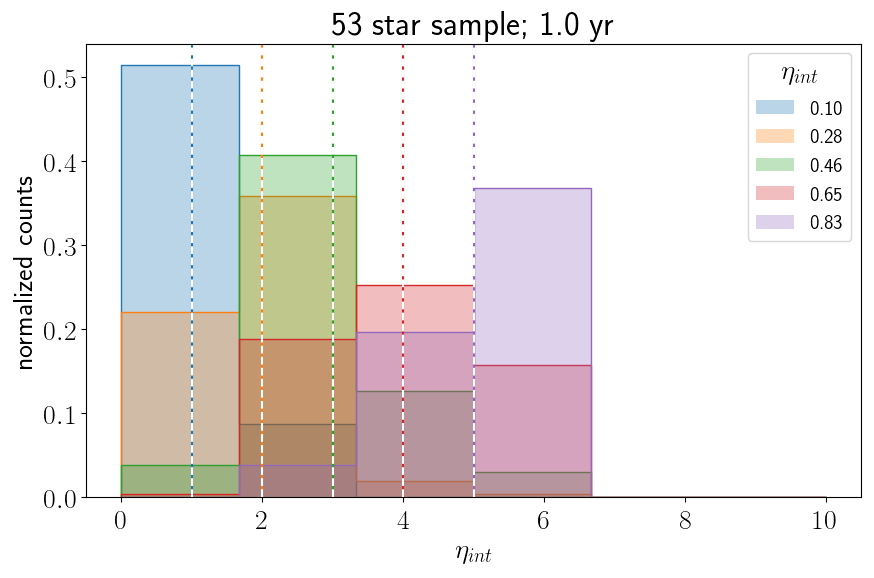

In [37]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_xlabel("$\eta_{int}$")
ax.set_ylabel("normalized counts")
#ax.set_ylabel("median \# of full planet spectra")
ax.set_title("%i star sample; %.1f yr" %(NBIAS, wantexp_yr))

xrange = (0, 10)

ic = 0
for i in range(0,ns_eta.shape[0])[::20]:
    c = "C%i" %ic
    ax.hist(ns_eta[i,:], bins = 6, alpha = .3, color = c, label = "%0.2f" %eta_interesting[i], normed=True, range = xrange);
    ax.hist(ns_eta[i,:], bins = 6, alpha = 1.0, histtype="step", color = c, normed=True, range = xrange);
    ax.axvline(np.median(ns_eta[i,:]), color = c)
    ax.axvline(np.median(ns_eta[i,:]), color = "w", ls = "dashed")
    ic += 1
    
ax.legend(title = "$\eta_{int}$", fontsize = 14, ncol = 1)

# Detect Individual Molecular Bands

## Reproduce Feng et al. (2018) SNR scaling relationship

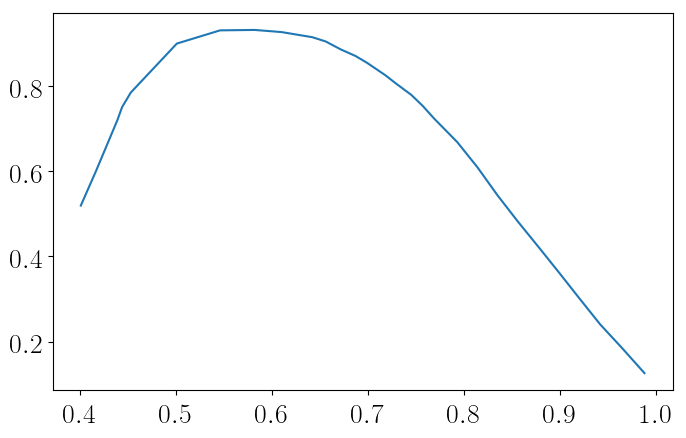

In [38]:
qe_data = np.genfromtxt("../inputs/QE_Feng_2018.txt", skip_header=1)
lam_qe = qe_data[:,0]
qe_lam = qe_data[:,1]

plt.plot(lam_qe, qe_lam)

In [39]:
luvoir_feng = spectroscopy.default_luvoir()

luvoir_feng.lammin = 0.4
luvoir_feng.lammax = 1.0

luvoir_feng.qe = 0.018
luvoir_feng.qe_lam = (lam_qe, qe_lam)

cn.telescope = luvoir_feng

cn.star.Rs = 1.0
cn.star.Teff = 5780.

cn.planet.distance = 5.0
cn.planet.a = 1.0

# Run count rates (necessary to generate new wavelength grid)
cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

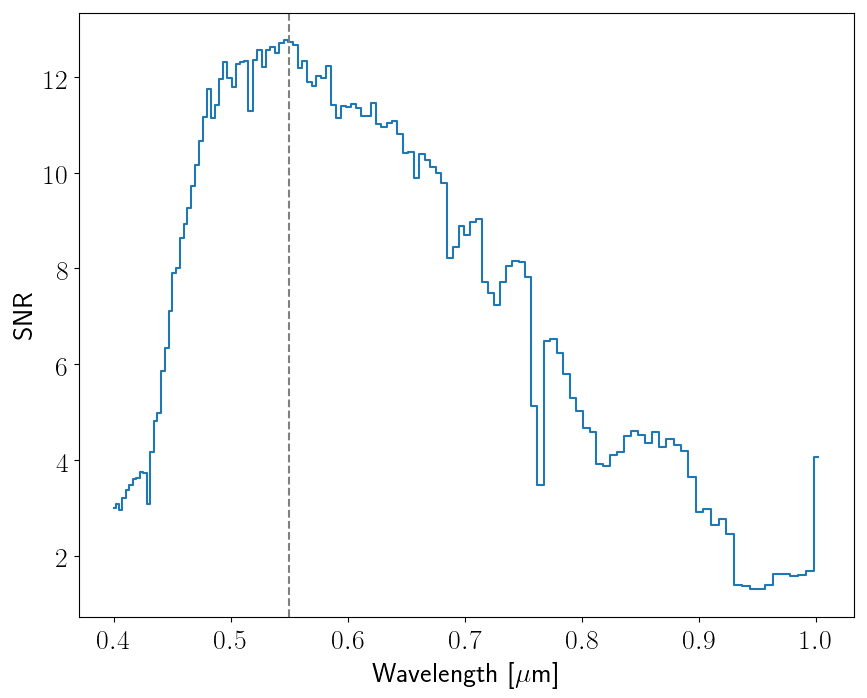

In [40]:
i550 = np.argmin(np.fabs(cn.lam - 0.550))

snr_feng = cn.SNRt #/ cn.SNRt[i550]

fig, ax = plt.subplots(figsize = (10,8))
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("SNR")
ax.plot(cn.lam, snr_feng, ls = "steps-mid")
ax.axvline(0.550, c = "gray", ls = "dashed")

SNR_O2A = SNR_550nm * 0.229


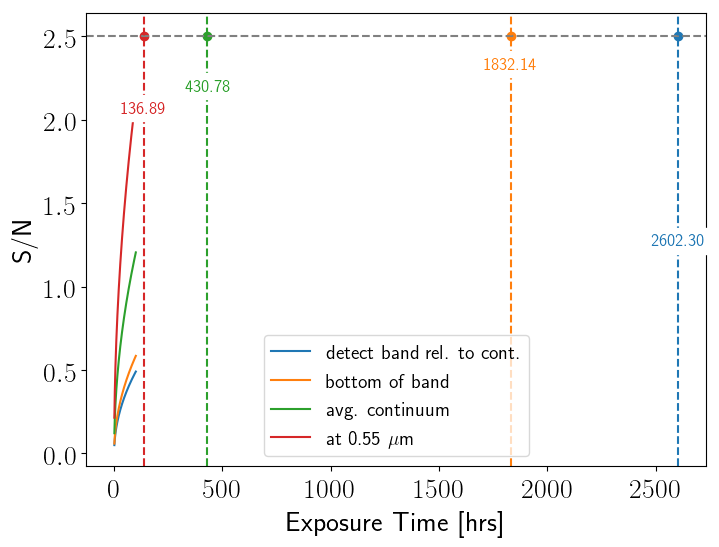

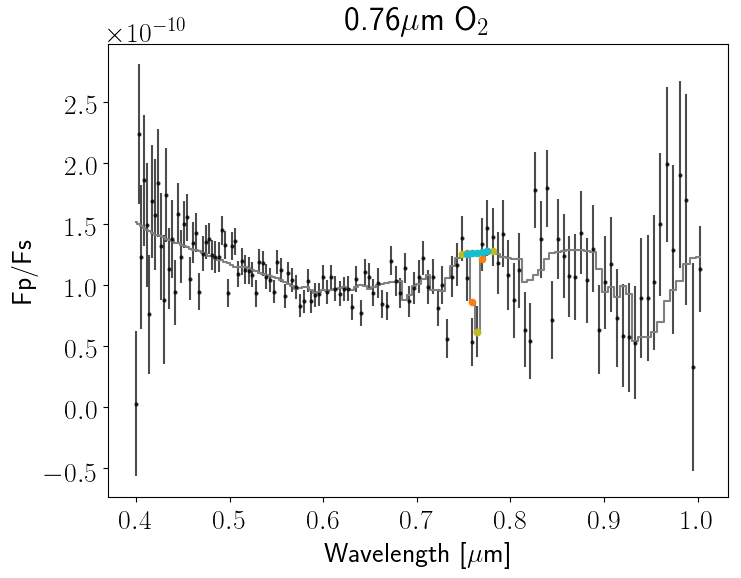

In [41]:
etimes = spectroscopy.determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", 
                                 plot_snr_curves=True, plot_spectrum=True, wantSNR=2.5)

rat_snr_o2a = np.sqrt(etimes[3] / etimes[0])

print("SNR_O2A = SNR_550nm * %.3f" %(rat_snr_o2a))

### Test additional molecular bands

SNR_H2O = SNR_550nm * 0.136
SNR_H2O = SNR_550nm * 0.159
SNR_H2O = SNR_550nm * 0.237
SNR_H2O = SNR_550nm * 0.283


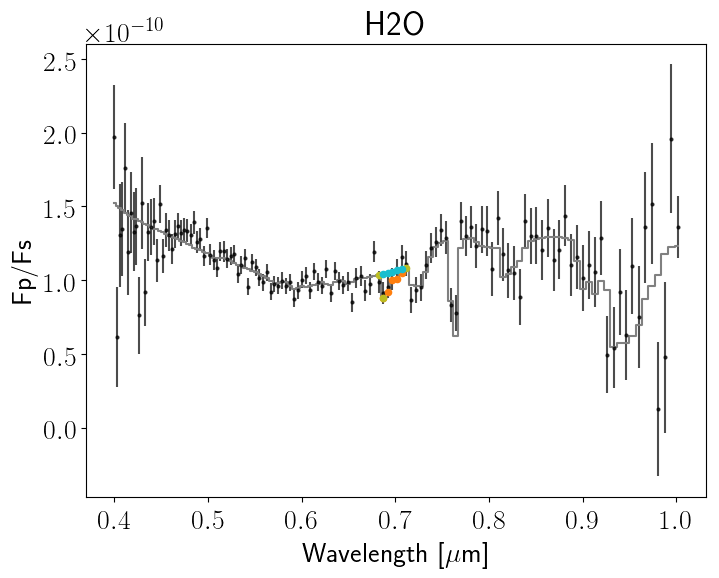

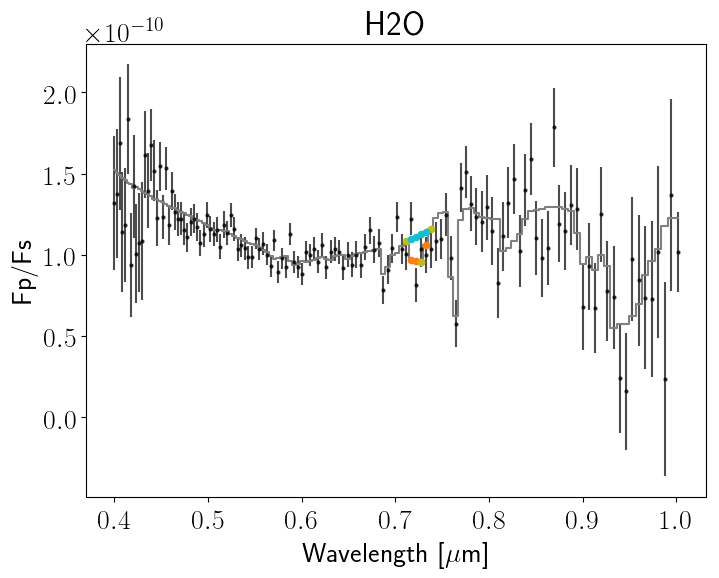

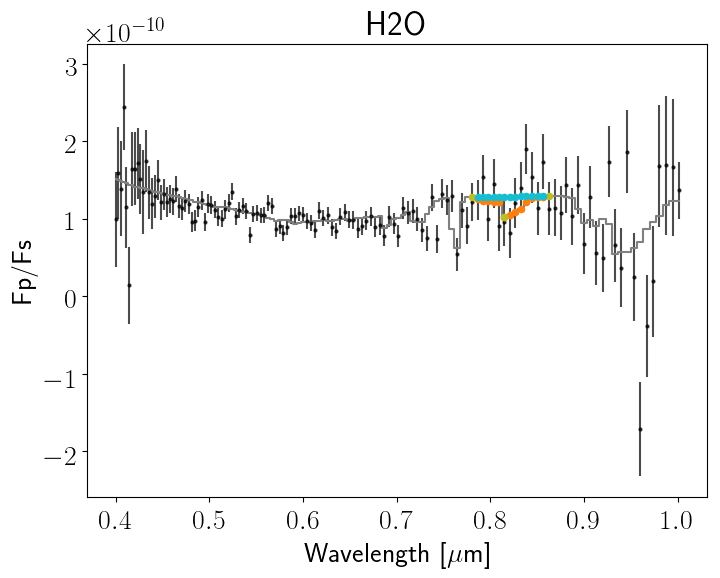

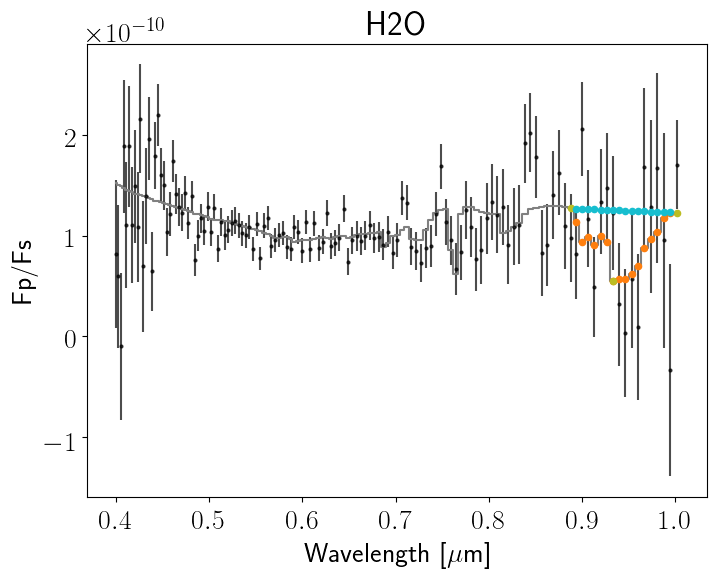

In [42]:
etimes = spectroscopy.determine_exposure_time(cn, [0.68, 0.71], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))


etimes = spectroscopy.determine_exposure_time(cn, [0.71, 0.74], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))


etimes = spectroscopy.determine_exposure_time(cn, [0.78, 0.86], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))


etimes = spectroscopy.determine_exposure_time(cn, [0.89, 1.0], title = "H2O", 
                                 plot_snr_curves=False, plot_spectrum=True, wantSNR=2.5)

rat_snr_h2o = np.sqrt(etimes[3] / etimes[0])

print("SNR_H2O = SNR_550nm * %.3f" %(rat_snr_h2o))

SNR_O3 = SNR_550nm * 0.110


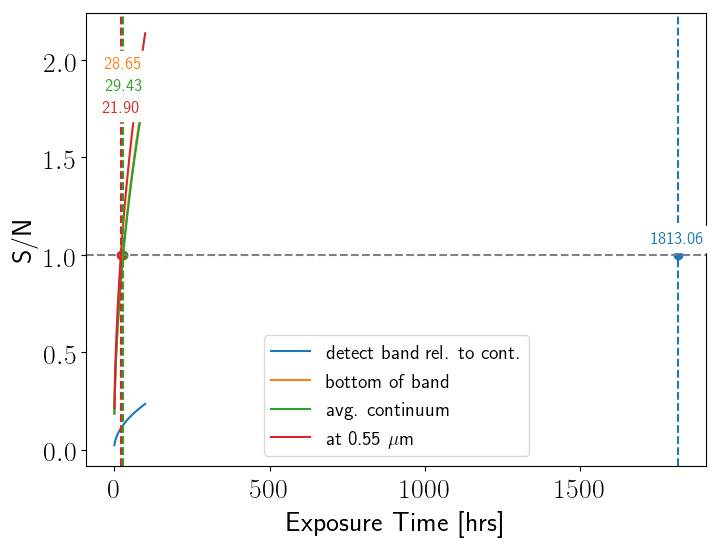

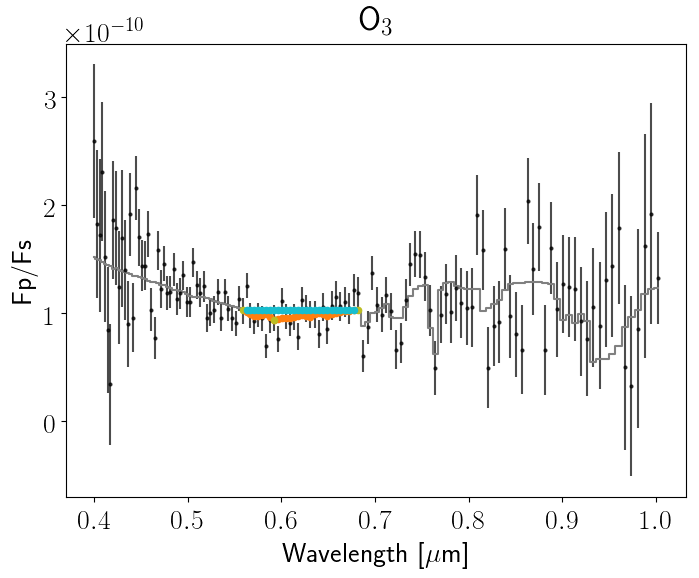

In [43]:
# vis
#cn.telescope = spectroscopy.default_luvoir(channel="vis", architecture="A")

# Run count rates (necessary to generate new wavelength grid)
#cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

# O3
etimes_O3 = spectroscopy.determine_exposure_time(cn, [0.56, 0.68], title = "O$_3$", 
                             plot_snr_curves=True, plot_spectrum=True, wantSNR=1.)

rat_snr_o3 = np.sqrt(etimes_O3[3] / etimes_O3[0])

print("SNR_O3 = SNR_550nm * %.3f" %(rat_snr_o3))

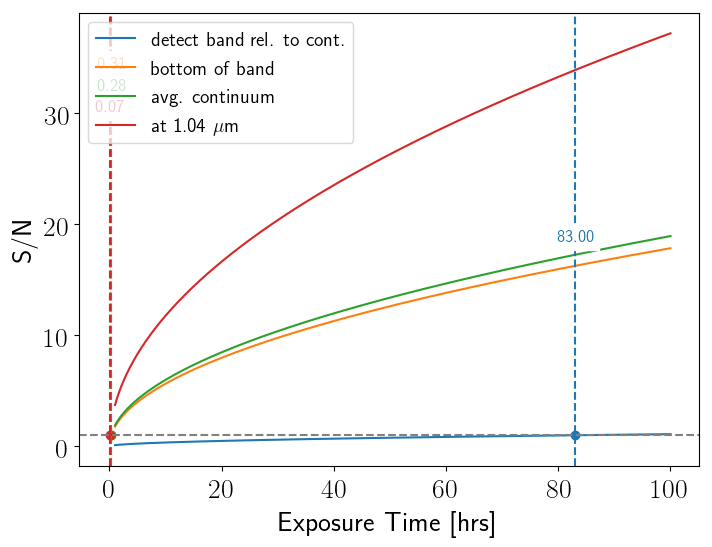

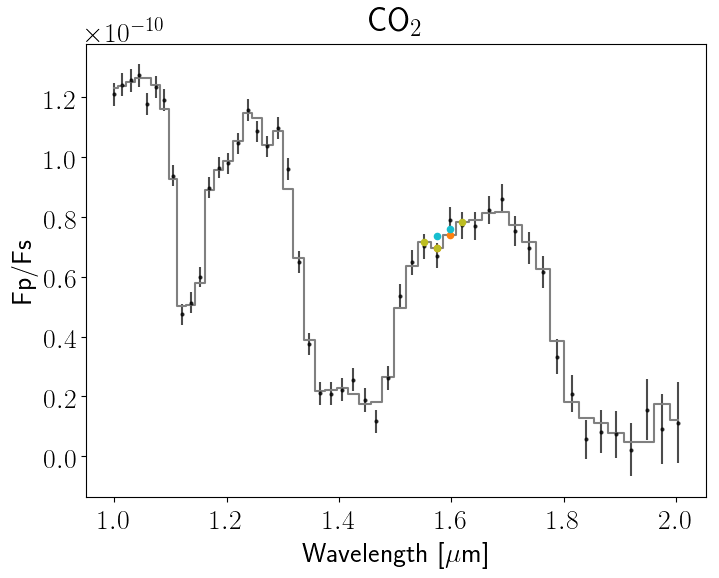

In [44]:
# NIR
cn.telescope = spectroscopy.default_luvoir(channel="NIR", architecture="A")
cn.telescope.resolution = 70.

# Run count rates (necessary to generate new wavelength grid)
cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

# CO2
etimes_CO2 = spectroscopy.determine_exposure_time(cn, [1.55, 1.63], title = "CO$_2$", 
                             plot_snr_curves=True, plot_spectrum=True, wantSNR=1.,
                             ref_lam = 1.05)

## Calculate time to detect molecular bands for each star in sample

In [45]:
molecule_list = ["O2", "O3", "CO2", "H2O"]

molecule_bands = {
    "O2"   : ( [0.75, 0.78], ), 
    "O3"   : ( [0.56, 0.68], ), 
    "CO2"  : ( [1.55, 1.63], ),
    "H2O"  : ( [0.68, 0.71], [0.71, 0.74], [0.78, 0.86], [0.89, 1.0])
}

def get_mband_channel(bandlims, architecture="A"):
    """
    Get the LUVOIR channel name for a given bandwidth, ``bandlims``
    """
    
    for chan in spectroscopy.CHANNELS:
        
        ts = spectroscopy.default_luvoir(channel=chan, architecture=architecture)
        
        if (bandlims[0] >= ts.lammin) and (bandlims[1] <= ts.lammax):
            
            return chan
        
    return None

def total_molec_bands(mol_dict):
    """
    """
    k = 0
    # Loop over each molecular band
    for molec in mol_dict.keys():
        for band in mol_dict[molec]: 
            k += 1
    return k

def get_mband_names():
    names = []
    # Loop over each molecular band
    for molec in molecule_list:
        for i, band in enumerate(molecule_bands[molec]): 
            names.append(molec + "_%i" %(i+1))
    return names

In [46]:
print(get_mband_channel(molecule_bands["O2"][0]))
print(total_molec_bands(molecule_bands))
print(get_mband_names())

vis
7
['O2_1', 'O3_1', 'CO2_1', 'H2O_1', 'H2O_2', 'H2O_3', 'H2O_4']


In [47]:
wantSNR_bands = 10.0
architecture = "A"

# Perform calculation for all stars in biased sample
biased_sample = spectroscopy.read_luvoir_stars()
Ndraw = len(biased_sample["dist"])
Nbands = total_molec_bands(molecule_bands) 

np.random.seed(seed=None)

# Allocate memory for exposure times
tpmbs = np.zeros((Ndraw, Nbands, 4))

# Loop over stars in this sample
for i in range(Ndraw):
    
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = spectroscopy.prep_ith_star(cn, i)
    
    k = 0
    # Loop over each molecular band
    for molec in molecule_list:
        for band in molecule_bands[molec]: 
        
            # Get the right LUVOIR channel for this band
            chan = get_mband_channel(band, architecture=architecture)
    
            # Set telescope model
            cn.telescope = spectroscopy.default_luvoir(channel=chan, architecture=architecture)
            
            # Run count rates (necessary to generate new wavelength grid)
            cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)
    
            # Get exposure times
            etimes = spectroscopy.determine_exposure_time(cn, band, title = molec, wantSNR=wantSNR_bands,
                                         plot_snr_curves=False, plot_spectrum=False)
            
            # Save band detection
            tpmbs[i,k,:] = np.array(etimes)
            
            k += 1
            
# etime_band, etime_bot, etime_cont, etime_fid

In [48]:
data2 = np.vstack([biased_sample["hip"], 
                  biased_sample["stype"], 
                  biased_sample["dist"], 
                  tpmbs[:,0,0], 
                  tpmbs[:,1,0], 
                  tpmbs[:,2,0], 
                  tpmbs[:,3,0], 
                  tpmbs[:,4,0], 
                  tpmbs[:,5,0], 
                  tpmbs[:,6,0]])
columns = np.hstack(["HIP", "type", "d [pc]", "O2 0.76", "O3 0.6", "CO2 1.6", "H2O 0.7", "H2O 0.73", "H2O 0.83", "H2O 0.94"])

isort = np.argsort(tpmbs[:,0,0])

table2 = pd.DataFrame(data2[:, isort].T, columns=columns)
table2.head(n = 10)

,HIP,type,d [pc],O2 0.76,O3 0.6,CO2 1.6,H2O 0.7,H2O 0.73,H2O 0.83,H2O 0.94
0,91772,K5,3.49174,13.646523994141068,414.9526615685651,2129.156969310094,88.30436661124807,62.341342081810396,7.270199193653562,1.5224467633726524
1,8102,G8V,3.65017,23.54993399756927,763.3355530732381,2680.517171497612,158.54349573935863,109.59347441683934,11.87232785458491,2.508722407232113
2,85523,K5,4.5405,26.149838266248565,759.2757559134217,5572.6071852943005,164.63712900220074,117.17614974343303,14.041899947917814,2.978740168327426
3,99461,K2V,6.01504,64.5851911964343,1824.2719321407908,16265.635438394707,401.01800547832636,285.64695621193454,34.26526272739599,7.379487304264881
4,12114,K3V,7.1803,100.48275279685411,2671.579508657773,32006.965023345707,602.0003033463124,434.1668579423393,54.236492020579654,11.783755022377234
5,113283,K4Vp,7.60919,117.02674449031952,3023.8107875846986,nan,690.0741829786435,500.62027536424677,63.65535482948102,13.943733466363629
6,84720,M0V,8.80204,152.68201513876733,3584.843884871617,nan,846.009818666838,628.0423591897063,86.24863782250246,nan
7,32984,K3V,8.71004,180.92828928029044,4560.450965499175,nan,1051.975285933781,765.9784576335652,98.52746432870309,21.633865009066934
8,57939,G8Vp,9.09174,250.399301784637,6786.079060887331,80360.90716215283,1515.9435979442449,1084.3577870844006,132.16747125668775,28.73164894855994
9,56997,G8Vvar,9.61169,296.2079284904314,7905.870247357595,99805.6617781966,1777.7429812106218,1275.331705919371,156.88911893568763,34.17604135680578


It's always more expensive to detect H2O at 0.8 um than 0.94


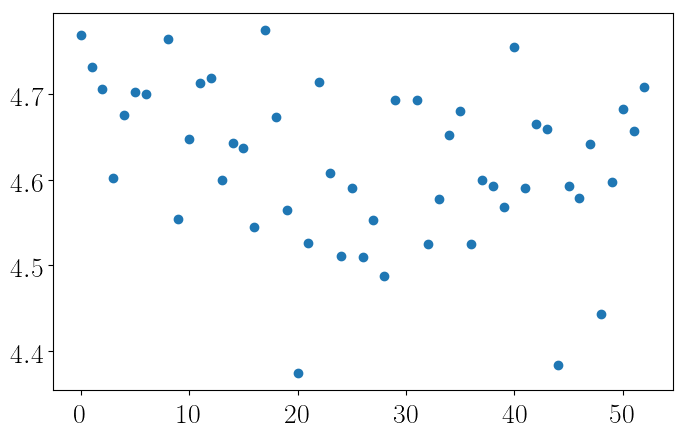

In [49]:
plt.plot(tpmbs[:,5,0] /  tpmbs[:,6,0], "o")
print("It's always more expensive to detect H2O at 0.8 um than 0.94")

In [50]:
print("------------------------------------")
for i in range(tpmbs.shape[1]):
    print(get_mband_names()[i])
    print("SNR_band = %.2f * SNR_continuum" %(np.nanmedian(np.sqrt(tpmbs[:,i,2] / tpmbs[:,i,0]))))
    #print("SNR_band = %.2f * SNR_fiducial" %(np.nanmedian(np.sqrt(tpmbs[:,i,3] / tpmbs[:,i,0]))))

------------------------------------
O2_1
SNR_band = 0.46 * SNR_continuum
O3_1
SNR_band = 0.08 * SNR_continuum
CO2_1
SNR_band = 0.06 * SNR_continuum
H2O_1
SNR_band = 0.18 * SNR_continuum
H2O_2
SNR_band = 0.22 * SNR_continuum
H2O_3
SNR_band = 0.65 * SNR_continuum
H2O_4
SNR_band = 1.18 * SNR_continuum


In [512]:
def run_hec_drm(Ndraw = 5, wantexp_days = 365., verbose = True, iremove = [], wantSNR_grid = None):
    """
    Run the LUVOIR Habitable Exoplanet Characterization (HEC) Design Reference Mission (DRM). 
    
    Parameters
    ----------
    Ndraw : int
        Number of stars drawn out of the total biased sample of habitable Earth-like candidates 
    wantexp_days : float
        Number of days willing to spend on science time for this program
    wantSNR_grid : list or numpy.array
        Desired SNR in each band; calculated via scaling from original ``wantSNR_grid`` 
        (must satisfy: ``len(wantSNR_grid) == len(bp_chan)``)
    iremove : list
        Indices of bandpasses to remove
    verbose : bool
        Use print statements? Good for a single example
        
    Returns
    -------
    """
    
    # Construct mask for bands we're keeping
    val = []
    for i in range(len(bp_names)):
        if i in iremove:
            val.append(False)
        else:
            val.append(True)
    val = np.array(val)

    # Randomly draw stellar sample indices
    idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)
    
    # Scale SNRs if need be
    if wantSNR_grid is not None:
        SNRfactor = (wantSNR_grid / wantSNR)**2
    else:
        SNRfactor = np.ones(tpbpcs_rect.shape[1])
    
    # Get exptimes for each star drawn
    tpbpcs_draws = SNRfactor*tpbpcs_rect[idraw, :]

    t_tot = np.zeros(Ndraw)
    
    # Loop over targets 
    for i in range(Ndraw): 
        t_uv = np.nansum(tpbpcs_draws[i, val & (bp_chan == 0)])
        t_vis = np.nansum(tpbpcs_draws[i, val & (bp_chan == 1)])
        t_nir = np.nansum(tpbpcs_draws[i, val & (bp_chan == 2)])
        t_toti = spectroscopy.apply_two_channels(np.array([t_uv, t_vis, t_nir]))
        t_tot[i] = t_toti
        if verbose:
            print("HIP%s - %s - %.2fpc" %(biased_sample["hip"][idraw[i]], biased_sample["stype"][idraw[i]], biased_sample["dist"][idraw[i]]))
            print("    - Complete Spectrum : %.2f days" %(t_toti / 24.))
            print("    - UV Spectrum : %.2f days" %(t_uv / 24.))
            print("    - Optical Spectrum : %.2f days" %(t_vis / 24.))
            print("    - NIR Spectrum : %.2f days" %(t_nir / 24.))
            print("    - O2 0.76 um : %.2f days" %(tpmbs[idraw[i],0,0] / 24.))
            print("    - O3 0.6 um : %.2f days" %(tpmbs[idraw[i],1,0] / 24.))
     
    # Calculate total exposure time for all Ndraw targets
    t_tot_sum = np.sum(t_tot)
    
    # Prioritize targets for fixed desired exposure time
    isort = np.argsort(t_tot)
    t_tot_cumsum = np.cumsum(t_tot[isort])
    viable = (t_tot_cumsum / 24.) < wantexp_days
    count_in_texp = np.sum(viable) 
    
    if verbose:
        print("---------------------FINAL TALLY---------------------")
        print("%.2f yrs for %i target's complete spectra (SNR=%i)" %(t_tot_sum / (24. * 356.), Ndraw, wantSNR))
        print("%.2f yrs for %i target's UV spectra (SNR=%i)" %(np.nansum(tpbpcs_draws[:, val & (bp_chan == 0)]) / (24. * 356.), Ndraw, wantSNR))
        print("%.2f yrs for %i target's optical spectra (SNR=%i)" %(np.nansum(tpbpcs_draws[:, val & (bp_chan == 1)]) / (24. * 356.), Ndraw, wantSNR))
        print("%.2f yrs for %i target's NIR spectra (SNR=%i)" %(np.nansum(tpbpcs_draws[:, val & (bp_chan == 2)]) / (24. * 356.), Ndraw, wantSNR))
        #print("%.2f yrs for %i target's O2 at 0.76 um (SNR=%i)" %(np.nansum(tpmbs[idraw,0,0]) / (24. * 356.), Ndraw, wantSNR_bands))
        #print("%.2f yrs for %i target's O3 at 0.6 um (SNR=%i)" %(np.nansum(tpmbs[idraw,1,0]) / (24. * 356.), Ndraw, wantSNR_bands))
        print("%i spectra in %i days (%i desired for program)" %(count_in_texp, t_tot_cumsum[viable][-1] / 24., wantexp_days))        

    return t_tot[isort], count_in_texp

In [518]:
np.random.seed(seed = 0)
t_tot_sort, count_in_texp = run_hec_drm(Ndraw = 5, iremove = [])

HIP19335 - F7V - 21.26pc
    - Complete Spectrum : 25938.09 days
    - UV Spectrum : 25938.09 days
    - Optical Spectrum : 95.18 days
    - NIR Spectrum : 106.80 days
    - O2 0.76 um : 230.63 days
    - O3 0.6 um : 6136.88 days
HIP26394 - G3IV - 18.23pc
    - Complete Spectrum : 15233.46 days
    - UV Spectrum : 15233.46 days
    - Optical Spectrum : 98.33 days
    - NIR Spectrum : 248.85 days
    - O2 0.76 um : 216.79 days
    - O3 0.6 um : 6417.43 days
HIP80337 - G3/G5V - 12.78pc
    - Complete Spectrum : 2772.19 days
    - UV Spectrum : 2772.19 days
    - Optical Spectrum : 14.05 days
    - NIR Spectrum : 14.42 days
    - O2 0.76 um : 32.37 days
    - O3 0.6 um : 833.48 days
HIP96895 - G2V - 21.29pc
    - Complete Spectrum : 20862.56 days
    - UV Spectrum : 20862.56 days
    - Optical Spectrum : 78.64 days
    - NIR Spectrum : 0.00 days
    - O2 0.76 um : 199.33 days
    - O3 0.6 um : 4737.46 days
HIP76829 - F5IV-V - 17.44pc
    - Complete Spectrum : 336.19 days
    - UV Spectrum

In [519]:
print("Indices to use for removing bandpasses:")
print("---------------------------------------")
for i in range(len(bp_names)):
    print("%s: %i" %(bp_names[i], i))
print("---------------------------------------")

Indices to use for removing bandpasses:
---------------------------------------
UV 1: 0
UV 2: 1
UV 3: 2
UV 4: 3
UV 5: 4
UV 6: 5
vis 1: 6
vis 2: 7
vis 3: 8
vis 4: 9
NIR 1: 10
NIR 2: 11
NIR 3: 12
NIR 4: 13
---------------------------------------


HIP19335 - F7V - 21.26pc
    - Complete Spectrum : 25938.09 days
    - UV Spectrum : 25938.09 days
    - Optical Spectrum : 95.18 days
    - NIR Spectrum : 106.80 days
    - O2 0.76 um : 230.63 days
    - O3 0.6 um : 6136.88 days
HIP26394 - G3IV - 18.23pc
    - Complete Spectrum : 15233.46 days
    - UV Spectrum : 15233.46 days
    - Optical Spectrum : 98.33 days
    - NIR Spectrum : 248.85 days
    - O2 0.76 um : 216.79 days
    - O3 0.6 um : 6417.43 days
HIP80337 - G3/G5V - 12.78pc
    - Complete Spectrum : 2772.19 days
    - UV Spectrum : 2772.19 days
    - Optical Spectrum : 14.05 days
    - NIR Spectrum : 14.42 days
    - O2 0.76 um : 32.37 days
    - O3 0.6 um : 833.48 days
HIP96895 - G2V - 21.29pc
    - Complete Spectrum : 20862.56 days
    - UV Spectrum : 20862.56 days
    - Optical Spectrum : 78.64 days
    - NIR Spectrum : 0.00 days
    - O2 0.76 um : 199.33 days
    - O3 0.6 um : 4737.46 days
HIP76829 - F5IV-V - 17.44pc
    - Complete Spectrum : 336.19 days
    - UV Spectrum

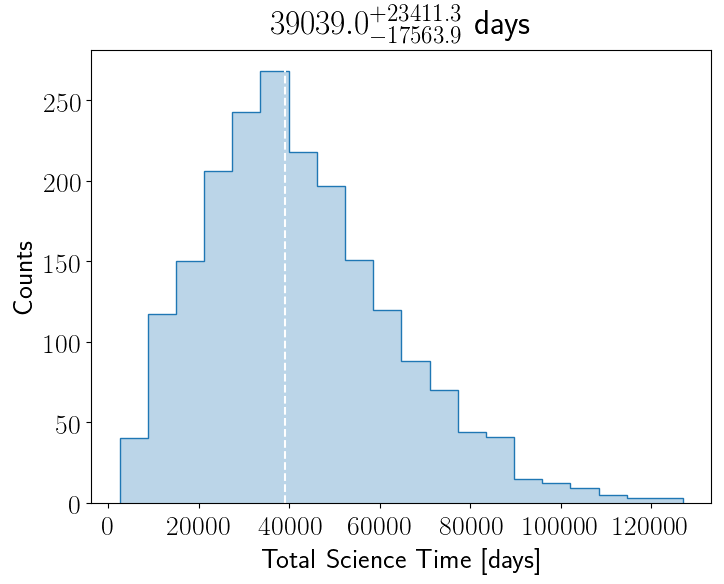

In [515]:
# No Bands Removed
iremove = []
np.random.seed(seed = 0)
t_tot_sort, count_in_texp = run_hec_drm(Ndraw = 5, iremove = iremove)

Xdraw = 2000
np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp = run_hec_drm(verbose = False, iremove = iremove)
    t_totx[x] = np.sum(t_tot_sort)

# Plot exposure time hist
fig, ax = plt.subplots(1, figsize = (8,6))
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(ctime_sum, bins = 20, alpha = .3, color = "C0");
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = "C0");
ax.axvline(q_50, color = "w", ls = "dashed")

HIP19335 - F7V - 21.26pc
    - Complete Spectrum : 122.87 days
    - UV Spectrum : 27.69 days
    - Optical Spectrum : 95.18 days
    - NIR Spectrum : 106.80 days
    - O2 0.76 um : 230.63 days
    - O3 0.6 um : 6136.88 days
HIP26394 - G3IV - 18.23pc
    - Complete Spectrum : 125.64 days
    - UV Spectrum : 27.31 days
    - Optical Spectrum : 98.33 days
    - NIR Spectrum : 114.73 days
    - O2 0.76 um : 216.79 days
    - O3 0.6 um : 6417.43 days
HIP80337 - G3/G5V - 12.78pc
    - Complete Spectrum : 16.90 days
    - UV Spectrum : 2.85 days
    - Optical Spectrum : 14.05 days
    - NIR Spectrum : 14.42 days
    - O2 0.76 um : 32.37 days
    - O3 0.6 um : 833.48 days
HIP96895 - G2V - 21.29pc
    - Complete Spectrum : 78.64 days
    - UV Spectrum : 14.68 days
    - Optical Spectrum : 78.64 days
    - NIR Spectrum : 0.00 days
    - O2 0.76 um : 199.33 days
    - O3 0.6 um : 4737.46 days
HIP76829 - F5IV-V - 17.44pc
    - Complete Spectrum : 234.56 days
    - UV Spectrum : 120.85 days
    - 

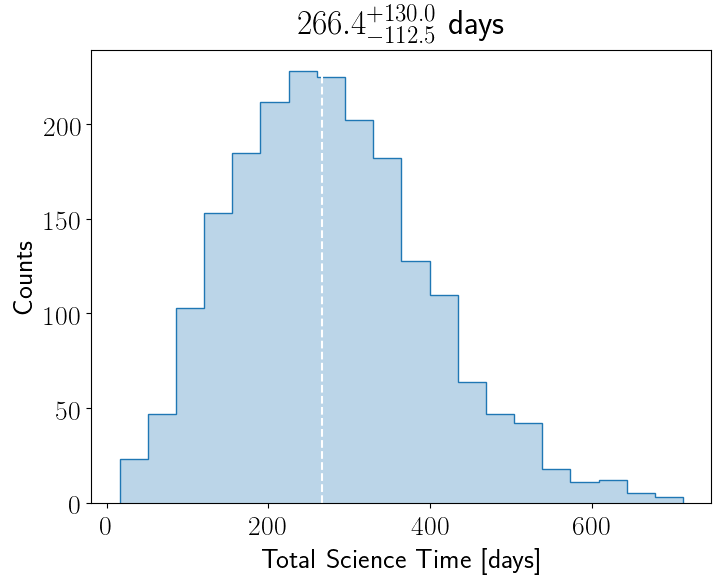

In [517]:
# 3 bands removed
iremove = [0,1,13]
np.random.seed(seed = 0)
t_tot_sort, count_in_texp = run_hec_drm(Ndraw = 5, iremove = iremove)

Xdraw = 2000
np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp = run_hec_drm(verbose = False, iremove = iremove)
    t_totx[x] = np.sum(t_tot_sort)

# Plot exposure time hist
fig, ax = plt.subplots(1, figsize = (8,6))
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(ctime_sum, bins = 20, alpha = .3, color = "C0");
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = "C0");
ax.axvline(q_50, color = "w", ls = "dashed")

HIP116085 - K2V - 16.87pc
    - Complete Spectrum : 80.34 days
    - UV Spectrum : 80.34 days
    - Optical Spectrum : 10.36 days
    - NIR Spectrum : 0.00 days
    - O2 0.76 um : 74.28 days
    - O3 0.6 um : 1616.20 days
HIP57757 - F8V - 10.93pc
    - Complete Spectrum : 46.27 days
    - UV Spectrum : 32.85 days
    - Optical Spectrum : 14.23 days
    - NIR Spectrum : 32.04 days
    - O2 0.76 um : 29.94 days
    - O3 0.6 um : 950.85 days
HIP32439 - F8V - 17.87pc
    - Complete Spectrum : 152.38 days
    - UV Spectrum : 150.02 days
    - Optical Spectrum : 54.63 days
    - NIR Spectrum : 97.74 days
    - O2 0.76 um : 128.12 days
    - O3 0.6 um : 3529.91 days
HIP26394 - G3IV - 18.23pc
    - Complete Spectrum : 277.70 days
    - UV Spectrum : 179.37 days
    - Optical Spectrum : 98.33 days
    - NIR Spectrum : 248.85 days
    - O2 0.76 um : 216.79 days
    - O3 0.6 um : 6417.43 days
HIP40843 - F6V - 18.27pc
    - Complete Spectrum : 258.61 days
    - UV Spectrum : 194.29 days
    - Opti

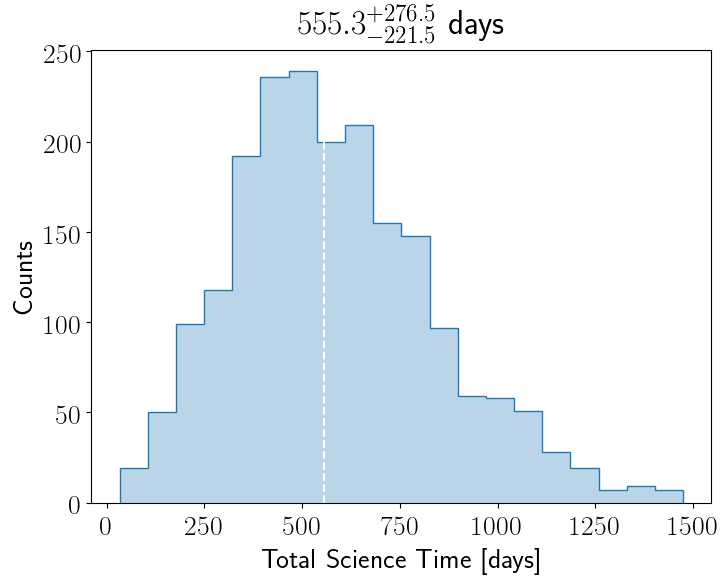

In [496]:
# No bands removed, but scaling SNR for two UV bands
iremove = []
wantSNR_grid = np.array([10.0 for i in range(len(bp_names))])
wantSNR_grid[0] = 1.0
wantSNR_grid[1] = 1.0

np.random.seed(seed = 1)
res = run_hec_drm(Ndraw = 5, iremove = iremove, wantSNR_grid = wantSNR_grid)

Xdraw = 2000
np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp = run_hec_drm(verbose = False, iremove = iremove, wantSNR_grid = wantSNR_grid)
    t_totx[x] = np.sum(t_tot_sort)

# Plot exposure time hist
fig, ax = plt.subplots(1, figsize = (8,6))
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(ctime_sum, bins = 20, alpha = .3, color = "C0");
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = "C0");
ax.axvline(q_50, color = "w", ls = "dashed")

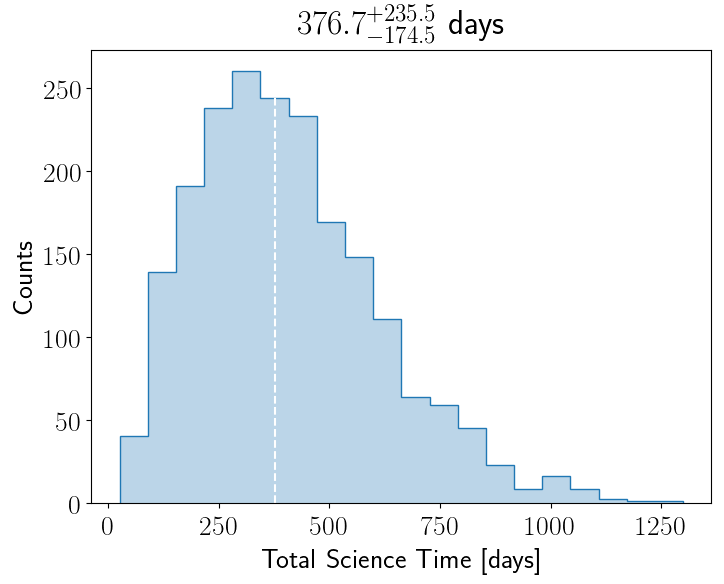

In [521]:
Ndraw = 5
Xdraw = 2000
iremove = [0,1]

np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp = run_hec_drm(Ndraw = Ndraw, verbose = False, iremove = iremove)
    t_totx[x] = np.sum(t_tot_sort)

# Plot exposure time hist
fig, ax = plt.subplots(1, figsize = (8,6))
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(ctime_sum, bins = 20, alpha = .3, color = "C0");
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = "C0");
ax.axvline(q_50, color = "w", ls = "dashed")

## Sensitivity to each eta_interesting star (target prioritization)

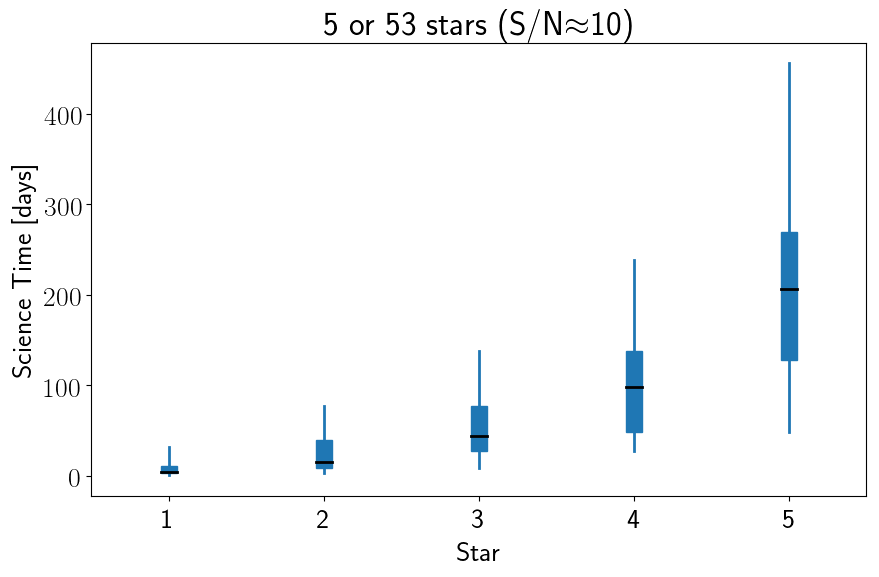

In [531]:
Ndraw = 5
Xdraw = 2000
iremove = [0,1]

np.random.seed(seed = None)

# Run DRM for Xdraw number of times
t_totx = np.zeros(Xdraw)
t_totx_bp = np.zeros((Xdraw, Ndraw))
for x in range(Xdraw):
    t_tot_sort, count_in_texp = run_hec_drm(Ndraw = Ndraw, verbose = False, iremove = iremove)
    t_totx[x] = np.sum(t_tot_sort)
    t_totx_bp[x,:] = t_tot_sort

fig2, ax2 = plt.subplots(figsize = (10,6))

data = [t_totx_bp[:,i] / 24. for i in range(Ndraw)]
color1 = "C0"
positions = np.arange(Ndraw) + 1.
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "k", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)

#_ = [i.set_color(color1) for i in ax2.get_yticklabels()];

ax2.set_ylabel("Science Time [days]")
ax2.set_title(r"%i or %i stars (S/N$\approx$%i)" %(Ndraw, NBIAS, wantSNR))
#ax2.set_yscale("log")

ax2.set_xlabel("Star")

ax2.set_xticks(np.arange(Ndraw)+1);
ax2.set_xticklabels(np.arange(Ndraw)+1); 

## Sensitivity to removed bandpasses

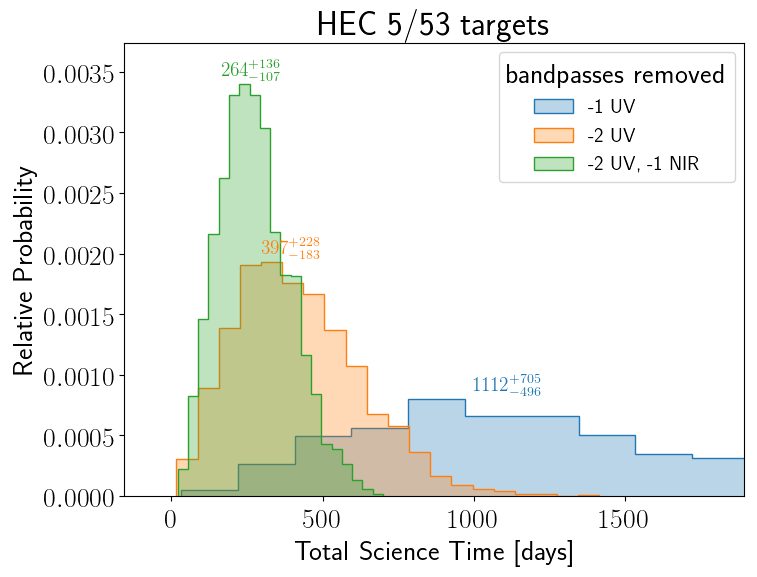

In [490]:
Xdraw = 2000
Ndraw = 5

np.random.seed(seed = None)

# Run DRM for Xdraw number of times
iremove = []
t_totx0 = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp = run_hec_drm(verbose = False, iremove = iremove)
    t_totx0[x] = np.sum(t_tot_sort)

# Run DRM for Xdraw number of times
iremove = [0]
t_totx1 = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp = run_hec_drm(verbose = False, iremove = iremove)
    t_totx1[x] = np.sum(t_tot_sort)

# Run DRM for Xdraw number of times
iremove = [0,1]
t_totx2 = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp = run_hec_drm(verbose = False, iremove = iremove)
    t_totx2[x] = np.sum(t_tot_sort)

# Run DRM for Xdraw number of times
iremove = [0,1,13]
t_totx3 = np.zeros(Xdraw)
for x in range(Xdraw):
    t_tot_sort, count_in_texp = run_hec_drm(verbose = False, iremove = iremove)
    t_totx3[x] = np.sum(t_tot_sort)

# Plot exposure time hist
fig, ax = plt.subplots(1, figsize = (8,6))
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Relative Probability")
ax.set_title("HEC %i/%i targets" %(Ndraw, NBIAS))

labels = []
handles = []

"""
t_totx = t_totx0
color = "C3"
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
h = ax.hist(ctime_sum, bins = 20, alpha = .3, color = color, normed=True);
ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = color, normed=True);
ax.axvline(q_50, color = "w", ls = "dashed")
ax.text(q_50, np.max(h[0]), result, color = color, ha = "center", va = "bottom", fontsize = 14)
"""

labels.append("-1 UV")
t_totx = t_totx1
color = "C0"
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%i^{+%i}_{-%i}$" %(q_50, q_p, q_m)
h = ax.hist(ctime_sum, bins = 20, alpha = .3, color = color, normed=True);
h2 = ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = color, normed=True);
handles.append((h[2][0], h2[2][0]))
#ax.axvline(q_50, color = "w", ls = "dashed")
ax.text(q_50, np.max(h[0]), result, color = color, ha = "center", va = "bottom", fontsize = 14)

ax.set_xlim(right=0.50*np.max(h[1]))

labels.append("-2 UV")
t_totx = t_totx2
color = "C1"
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%i^{+%i}_{-%i}$" %(q_50, q_p, q_m)
h = ax.hist(ctime_sum, bins = 20, alpha = .3, color = color, normed=True);
h2 = ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = color, normed=True);
handles.append((h[2][0], h2[2][0]))
#ax.axvline(q_50, color = "w", ls = "dashed")
ax.text(q_50, np.max(h[0]), result, color = color, ha = "center", va = "bottom", fontsize = 14)

labels.append("-2 UV, -1 NIR")
t_totx = t_totx3
color = "C2"
ctime_sum = t_totx / 24.
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%i^{+%i}_{-%i}$" %(q_50, q_p, q_m)
h = ax.hist(ctime_sum, bins = 20, alpha = .3, color = color, normed=True);
h2 = ax.hist(ctime_sum, bins = 20, alpha = 1.0, histtype="step", color = color, normed=True);
handles.append((h[2][0], h2[2][0]))
#ax.axvline(q_50, color = "w", ls = "dashed")
ax.text(q_50, np.max(h[0]), result, color = color, ha = "center", va = "bottom", fontsize = 14)

ax.set_ylim(top = 1.1*np.max(h[0]))
ax.legend(handles, labels, fontsize = 14, title = "bandpasses removed")

## Sensitivity to eta_interesting

In [491]:
iremove = [0,1]

Xdraw = 100
Ndraws = np.arange(1,NBIAS)
wantdays = np.linspace(5, 365*2, 20)
zcube = np.zeros((len(Ndraws), len(wantdays), Xdraw))

np.random.seed(seed = None)

for i in range(len(Ndraws)):
    for j in range(len(wantdays)):
        for k in range(Xdraw):
            t_tot_sort, count_in_texp = run_hec_drm(Ndraw = Ndraws[i], wantexp_days = wantdays[j], verbose = False, iremove = iremove) 
            zcube[i,j,k] = count_in_texp

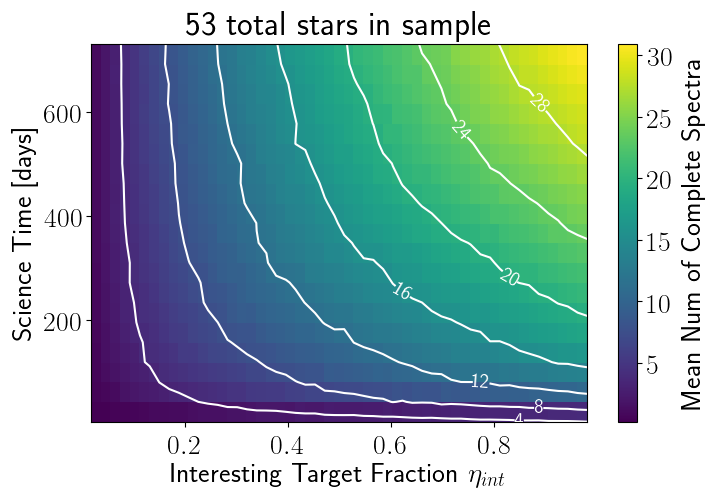

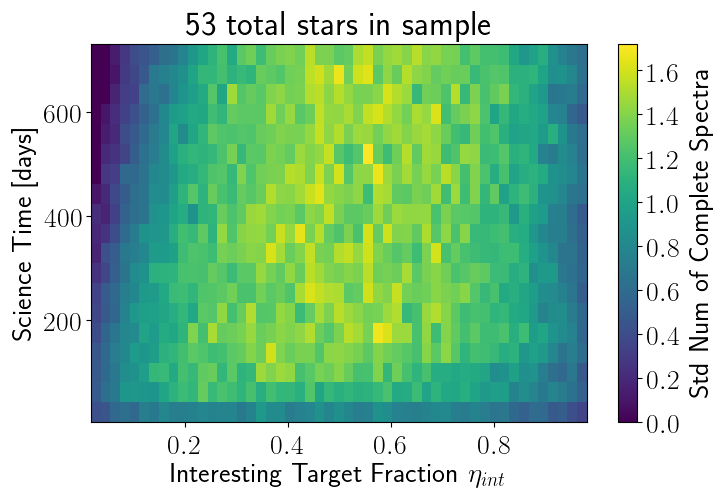

In [492]:
zmean = np.mean(zcube, axis = 2)

fig, ax = plt.subplots()
ax.set_title("%i total stars in sample" %NBIAS)
ax.set_xlabel("Interesting Target Fraction $\eta_{int}$")
ax.set_ylabel("Science Time [days]")
p = ax.pcolor(Ndraws / float(NBIAS), wantdays, zmean.T)
cln = ax.contour(Ndraws / float(NBIAS), wantdays, zmean.T, colors="w")
plt.clabel(cln, inline=1, fontsize=14, inline_spacing=1, fmt = "%i")
fig.colorbar(p, label = "Mean Num of Complete Spectra")

zstd = np.std(zcube, axis = 2)

fig, ax = plt.subplots()
ax.set_title("%i total stars in sample" %NBIAS)
ax.set_xlabel("Interesting Target Fraction $\eta_{int}$")
ax.set_ylabel("Science Time [days]")
p = ax.pcolor(Ndraws / float(NBIAS), wantdays, zstd.T)
fig.colorbar(p, label = "Std Num of Complete Spectra")

## Sensitivity to science program duration

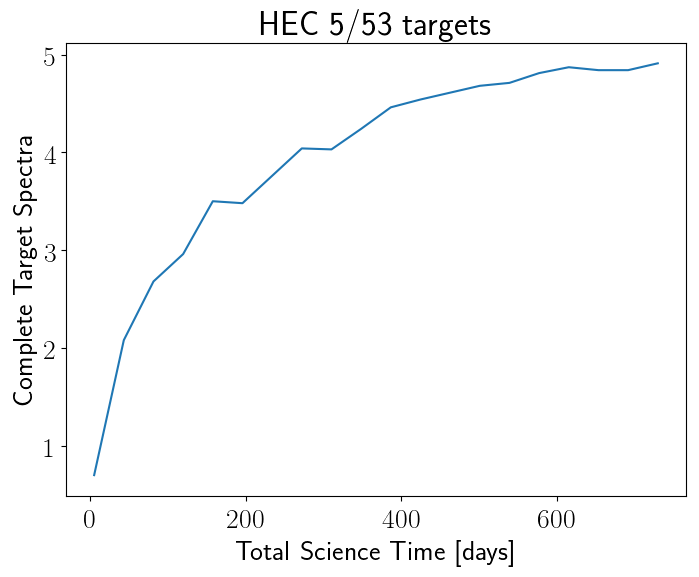

In [548]:
Ndraw = 5
idraw = np.argmin(np.fabs(Ndraw - Ndraws))

fig, ax = plt.subplots(1, figsize = (8,6))
ax.set_xlabel("Total Science Time [days]")
ax.set_ylabel("Complete Target Spectra")
ax.set_title("HEC %i/%i targets" %(Ndraw, NBIAS))
ax.plot(wantdays, np.mean(zcube[idraw,:,:], axis = 1))


## What does a representative observed spectrum look like?

In [322]:
def complete_spectrum_time(cn, Ahr_flat = 0.25, wantSNR = 10.0, bandwidth = 0.2,
                           plot = False, verbose = False):
    """
    Time for a complete spectrum

    Parameters
    ----------
    Ahr_flat : float
        Flat albedo spectrum
    wanrSNR : float or array-like
        Desired SNR on spectrum (per bandpass if array-like)
    plot : bool
        Produce a plot?
    verbose : bool
        Print things?

    Returns
    -------
    t_tot : array-like
        total exposure time
    t_per_band_per_chan : list
        time per band per channel
    spectrum : tuple
        (lam, Cratio, Cobs, Csig)
    iwa : tuple
        (pct_obs_iwa, lammax_obs_iwa)

    """

    if plot: fig, ax = plt.subplots()

    cc = ["C0", "C2", "C3"]
    t_chan = np.zeros(len(spectroscopy.CHANNELS))
    Nbands_per_chan = np.zeros(len(spectroscopy.CHANNELS))
    t_per_band_per_chan = []
    full_lam = []
    full_dlam = []
    full_Cobs = []
    full_Cratio = []
    full_Csig = []
    pct_obs_iwa = []
    lammax_obs_iwa = []
    lam_extrema = []
    
    ibp = 0

    # Loop over telescope channels
    for j, channel in enumerate(spectroscopy.CHANNELS):

        t_tmp = []

        # Get the channel specific telescope parameters
        luvoir = spectroscopy.default_luvoir(channel=channel)
        cn.telescope = luvoir

        if verbose: print(channel, luvoir.lammin, luvoir.lammax)

        lam_extrema.append(luvoir.lammin)
        lam_extrema.append(luvoir.lammax)

        # Calculate the bandpass edges
        edges = spectroscopy.calculate_bandpass_edges(luvoir.lammin, luvoir.lammax, bandwidth = bandwidth)

        # Calculate the number of bandpasses
        Nbands = len(edges) - 1
        Nbands_per_chan[j] = Nbands

        # Run count rates (necessary to generate new wavelength grid)
        cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

        # Calculate how much of the spectrum is observable
        pct, lammax_obs = spectroscopy.calc_observable_spectrum(cn)
        pct_obs_iwa.append(pct)
        lammax_obs_iwa.append(lammax_obs)

        # Loop over bandpasses
        for i in range(Nbands):
            
            if (type(wantSNR) is float) or (type(wantSNR) is int):
                wSNR = wantSNR
            else:
                wSNR = wantSNR[ibp]

            # Get the max, min, and middle wavelenths for this bandpass
            lammin = edges[i]
            lammax = edges[i+1]
            lammid = 0.5*(lammax + lammin)

            # Set telescope wavelength range
            cn.telescope.lammin = lammin
            cn.telescope.lammax = lammax

            if channel == "UV":
                cn.telescope.lam = np.array([lammid])
                cn.telescope.dlam = np.array([lammax - lammin])

            # Set spectrum to use for exposure time calcs
            # Using flat spectrum so not biased by bottom of bands
            Ahr_flat  = Ahr_flat * np.ones(len(spectroscopy.LAMHR))

            # Run count rates (necessary to generate new wavelength grid)
            cn.run_count_rates(Ahr_flat, spectroscopy.LAMHR, spectroscopy.FSTAR)

            # Calculate exposure times to wantSNR
            etimes = spectroscopy.determine_exposure_time(cn, None, plot_snr_curves=False,
                        plot_spectrum=False, wantSNR=wSNR, ref_lam = lammid)
            t_ref_lam = etimes[-1]

            # Re-do count rate calcs for true Earth spectrum
            cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)

            # Draw random samples of data for a plot
            cn.make_fake_data(texp=t_ref_lam)

            if verbose: print(lammid, t_ref_lam)

            # Plot
            if plot:
                ax.axvspan(lammin, lammax, alpha = 0.2, color = cc[j])
                #ax.plot(cn.lam, cn.Cratio, ls = "steps-mid", color = "grey", zorder = 100)
                ax.plot(cn.lam, cn.Cobs, "o", ms = 3.0, alpha = 1.0, color = "w", zorder = 70)
                ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "o", ms = 2.0, alpha = 0.7, color = "k", zorder = 70)
                ax.set_xlabel("Wavelength [$\mu$m]")
                ax.set_ylabel("$F_p / F_s$")

            # Save values
            t_tmp.append(t_ref_lam)
            full_lam.append(cn.lam)
            full_dlam.append(cn.dlam)
            full_Cratio.append(cn.Cratio)
            full_Cobs.append(cn.Cobs)
            full_Csig.append(cn.Csig)

            # Add time
            if np.isfinite(t_ref_lam):
                t_chan[j] += t_ref_lam
                
            ibp += 1

        # Save tmp times per band
        t_per_band_per_chan.append(t_tmp)

    # Deal with the "two channels at a time" thing
    t_tot = spectroscopy.apply_two_channels(t_chan)

    spectrum = (np.array(full_lam),
                np.array(full_dlam),
                np.array(full_Cratio),
                np.array(full_Cobs),
                np.array(full_Csig))
    iwa = (pct_obs_iwa, lammax_obs_iwa)

    if plot:
        lam_extrema = np.array(lam_extrema)
        cn.telescope.lammin = np.min(lam_extrema)
        cn.telescope.lammax = np.max(lam_extrema)
        cn.telescope.resolution = 140.
        # Re-do count rate calcs for true Earth spectrum
        cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)
        ax.plot(cn.lam, cn.Cratio, color = "grey", zorder = 80, lw = 3.0)
        ax.plot(cn.lam, cn.Cratio, color = "w", zorder = 80, lw = 2.0)

    return t_tot, t_per_band_per_chan, spectrum, iwa

In [332]:
cn.planet.distance = 5.0
cn.planet.a = 1.0
cn.star.Rs = 1.0
cn.star.Teff = 5780.

wantSNR_grid = np.array([10.0 for i in range(len(bp_names))])
wantSNR_grid[0] = 1.0
wantSNR_grid[1] = 1.0

output = complete_spectrum_time(cn, Ahr_flat = 0.25, wantSNR = wantSNR_grid, bandwidth = 0.2,
                       plot = False, verbose = False)
spectrum = output[2]

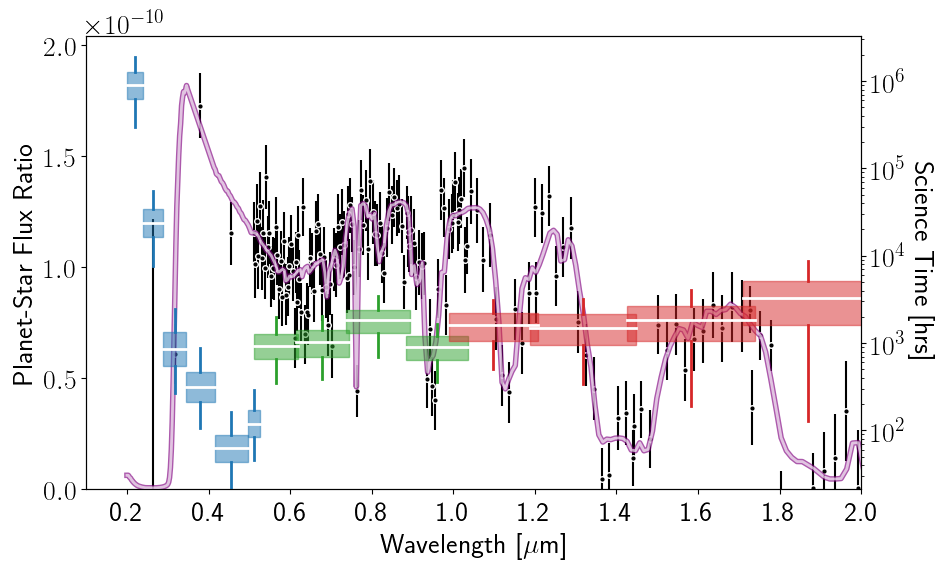

In [333]:
iremove = []
cc = ["C0", "C2", "C3"]

fig, ax = plt.subplots(figsize = (10,6))

Xdraw = len(tpbpcs_draws_tots[0][0])

ax2 = ax.twinx()

ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Planet-Star Flux Ratio")
for i in range(len(bp_names)):
    if i not in iremove:
        ax.plot(spectrum[0][i], spectrum[3][i], "o", ms = 4.0, alpha = 1.0, color = "w", zorder = 70)
        ax.errorbar(spectrum[0][i], spectrum[3][i], yerr=spectrum[4][i], fmt = "o", ms = 2.0, alpha = 1.0, color = "k", zorder = 70)

cn.telescope.lammin = 0.2
cn.telescope.lammax = 2.0
cn.telescope.resolution = 140.
# Re-do count rate calcs for true Earth spectrum
cn.run_count_rates(spectroscopy.AHR, spectroscopy.LAMHR, spectroscopy.FSTAR)
ax.plot(cn.lam, cn.Cratio, color = "purple", zorder = 80, lw = 4.0, alpha = 0.65)
ax.plot(cn.lam, cn.Cratio, color = "w", zorder = 80, lw = 2.0, alpha = 0.65)
ax.set_ylim(bottom=0.0)

# Transform quantities for boxplot
tmp = [np.zeros((len(tpbpcs_draws_tots[i]), Xdraw)) for i in range(len(spectroscopy.CHANNELS))]
for i in range(Xdraw):
    for j in range(len(tpbpcs_draws_tots)):
        for k in range(len(tpbpcs_draws_tots[j])):
            tmp[j][k,i] = tpbpcs_draws_tots[j][k][i]

icount = 0
for j in range(len(tmp)):
    
    data = []
    positions = []
    widths = []
    for i in range(tmp[j].shape[0]):
        data.append(tmp[j][i,:])
        positions.append(np.mean(specs[0][0][icount]))
        widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0] + np.mean(specs[0][1][icount][:]))
        
        comp_str = "$%i \%%$" %(100.*np.mean(comp_draws_stars[j][i]))
        #ax2.text(positions[i], np.median(tmp[j][i,:]) + 5.*np.std(tmp[j][i,:]), comp_str, 
        #         ha = "center", va = "top", fontsize = 12, color = cc[j])
        
        icount += 1
        
    color1 = cc[j]
    positions = np.array(positions)
    widths = np.array(widths)
    bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                      boxprops = {"color" : color1, "alpha" : 0.5}, 
                      whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                      capprops = {"color" : color1, "linewidth" : 0.0}, 
                      medianprops = {"color" : "w", "linewidth" : 2.0}, 
                      patch_artist=True, positions = positions, whis = [5, 95]); 

    for patch in bp1['boxes']:
        patch.set_facecolor(color1)
    
ax2.set_ylabel("Science Time [hrs]", labelpad = 22, rotation = 270)
#ax2.set_title(r"All %i targets (S/N$\approx$%i)" %(Ndraw, wantSNR))
ax2.set_yscale("log")

ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylim(bottom = 0.0)

ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax2.set_xlim(0.1, 2.0)

fig.savefig("/Users/Jake/Desktop/drm_test1.pdf", bbox_inches = "tight")

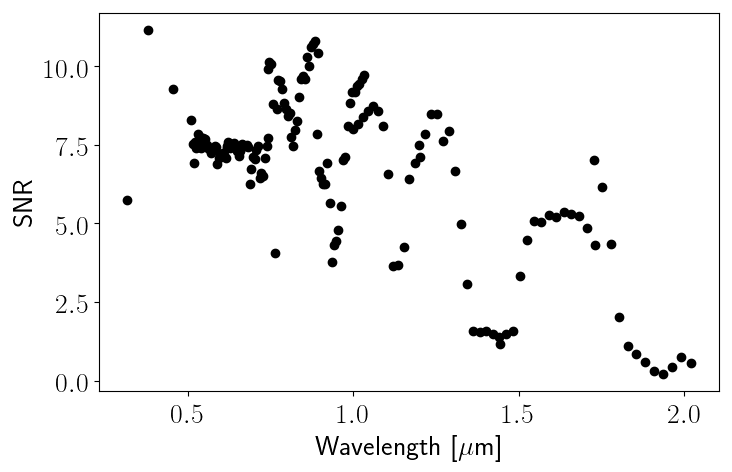

In [551]:
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("SNR")
for i in range(len(bp_names)):
    if i not in iremove:
        ax.plot(spectrum[0][i], spectrum[2][i]/spectrum[4][i], "o", alpha = 1.0, color = "k", zorder = 70)